In [1]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
import tensorflow as tf
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad
from sklearn import datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import tensorflow_probability as tfp
from tensorflow.keras import layers
import sklearn

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


## Data Preprocessing

In [3]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [70]:
area_weight=dataset.area[0]

In [72]:
area_weight_arr=area_weight.mean(dim="lon").values

In [73]:
area_weight_arr/=sum(area_weight_arr)

Text(0, 0.5, 'Weights')

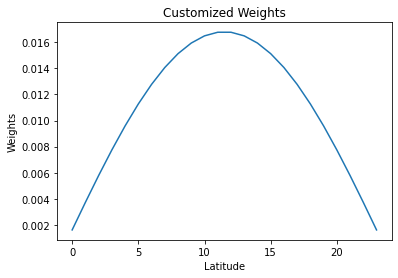

In [141]:
plt.plot(area_weight_arr)
plt.title("Customized Weights")
plt.xlabel("Latitude")
plt.ylabel("Weights")

In [4]:
X=X_s.copy()
Y_obs=Y_np.copy()
Y_shifted=Y.values.mean()
Y_std=Y.values.std()
Y=(Y.values-Y.values.mean())/(Y.values.std())
# Y=np.array([Yi.flatten() for Yi in Y])

In [5]:
Y=Y.reshape(250,24,48)

## Train, Test Split

In [6]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

## Model

In [7]:
BaseEstimator=sklearn.base.BaseEstimator

In [138]:
bandwidth=2
shift=1e-3

244.69193226422033


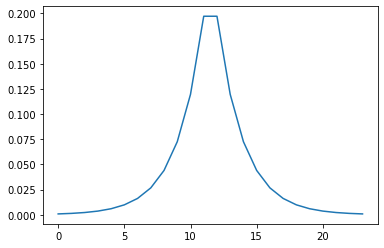

In [139]:
z=np.exp(-np.abs(np.arange(24,dtype=float)-11.5)/bandwidth+shift)
weights=z/np.sum(z)
print(z[11]/z[-1])
plt.plot(weights)

In [9]:
class DeConvNeuralNetwork(BaseEstimator):
    def __init__(self,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
        z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
        weights=z/kb.sum(z)
        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [10]:
DNN=DeConvNeuralNetwork(epochs=10000)

In [11]:
DNN.fit(X_train,Y_train)

Metal device set to: Apple M1 Max


2022-05-24 00:17:19.450884: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10000
7/7 [==============================] - 4s 333ms/step - loss: 0.1391 - root_mean_squared_error: 1.0312
Epoch 2/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.1251 - root_mean_squared_error: 0.9978
Epoch 3/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.1138 - root_mean_squared_error: 0.9645
Epoch 4/10000
7/7 [==============================] - 0s 38ms/step - loss: 0.1018 - root_mean_squared_error: 0.9220
Epoch 5/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0901 - root_mean_squared_error: 0.8604
Epoch 6/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0817 - root_mean_squared_error: 0.7852
Epoch 7/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0756 - root_mean_squared_error: 0.7108
Epoch 8/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0665 - root_mean_squared_error: 0.6416
Epoch 9/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.059

7/7 [==============================] - 0s 43ms/step - loss: 0.0280 - root_mean_squared_error: 0.2254
Epoch 72/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0274 - root_mean_squared_error: 0.2240
Epoch 73/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0260 - root_mean_squared_error: 0.2227
Epoch 74/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0273 - root_mean_squared_error: 0.2222
Epoch 75/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0266 - root_mean_squared_error: 0.2206
Epoch 76/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0250 - root_mean_squared_error: 0.2181
Epoch 77/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0254 - root_mean_squared_error: 0.2174
Epoch 78/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0239 - root_mean_squared_error: 0.2141
Epoch 79/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0249 - roo

Epoch 141/10000
7/7 [==============================] - 0s 36ms/step - loss: 0.0227 - root_mean_squared_error: 0.1833
Epoch 142/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0225 - root_mean_squared_error: 0.1827
Epoch 143/10000
7/7 [==============================] - 0s 39ms/step - loss: 0.0219 - root_mean_squared_error: 0.1821
Epoch 144/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0219 - root_mean_squared_error: 0.1812
Epoch 145/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0218 - root_mean_squared_error: 0.1818: 0s - loss: 0.0219 - root_mean_squared_error: 0.18
Epoch 146/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0209 - root_mean_squared_error: 0.1797
Epoch 147/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0211 - root_mean_squared_error: 0.1798
Epoch 148/10000
7/7 [==============================] - 0s 37ms/step - loss: 0.0206 - root_mean_squared_error: 0.1781
Epoch 149/100

7/7 [==============================] - 0s 43ms/step - loss: 0.0190 - root_mean_squared_error: 0.1609
Epoch 211/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0193 - root_mean_squared_error: 0.1622
Epoch 212/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0186 - root_mean_squared_error: 0.1610
Epoch 213/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0199 - root_mean_squared_error: 0.1622
Epoch 214/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0211 - root_mean_squared_error: 0.1637
Epoch 215/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0212 - root_mean_squared_error: 0.1644
Epoch 216/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0193 - root_mean_squared_error: 0.1616
Epoch 217/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0192 - root_mean_squared_error: 0.1616
Epoch 218/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.02

7/7 [==============================] - 0s 35ms/step - loss: 0.0177 - root_mean_squared_error: 0.1491
Epoch 281/10000
7/7 [==============================] - 0s 37ms/step - loss: 0.0187 - root_mean_squared_error: 0.1508
Epoch 282/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0180 - root_mean_squared_error: 0.1501
Epoch 283/10000
7/7 [==============================] - 0s 38ms/step - loss: 0.0183 - root_mean_squared_error: 0.1501
Epoch 284/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0175 - root_mean_squared_error: 0.1486
Epoch 285/10000
7/7 [==============================] - 0s 34ms/step - loss: 0.0184 - root_mean_squared_error: 0.1502
Epoch 286/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0184 - root_mean_squared_error: 0.1499
Epoch 287/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0184 - root_mean_squared_error: 0.1484
Epoch 288/10000
7/7 [==============================] - 0s 39ms/step - loss: 0.01

7/7 [==============================] - 0s 44ms/step - loss: 0.0177 - root_mean_squared_error: 0.1425
Epoch 351/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0180 - root_mean_squared_error: 0.1427
Epoch 352/10000
7/7 [==============================] - 0s 37ms/step - loss: 0.0184 - root_mean_squared_error: 0.1432
Epoch 353/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0175 - root_mean_squared_error: 0.1422
Epoch 354/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0169 - root_mean_squared_error: 0.1408
Epoch 355/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0171 - root_mean_squared_error: 0.1411
Epoch 356/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0176 - root_mean_squared_error: 0.1414
Epoch 357/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0174 - root_mean_squared_error: 0.1411
Epoch 358/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.01

7/7 [==============================] - 0s 34ms/step - loss: 0.0163 - root_mean_squared_error: 0.1354
Epoch 421/10000
7/7 [==============================] - 0s 39ms/step - loss: 0.0168 - root_mean_squared_error: 0.1360
Epoch 422/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0162 - root_mean_squared_error: 0.1348
Epoch 423/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0163 - root_mean_squared_error: 0.1347
Epoch 424/10000
7/7 [==============================] - 0s 39ms/step - loss: 0.0158 - root_mean_squared_error: 0.1340
Epoch 425/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0165 - root_mean_squared_error: 0.1350
Epoch 426/10000
7/7 [==============================] - 0s 34ms/step - loss: 0.0164 - root_mean_squared_error: 0.1346
Epoch 427/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0163 - root_mean_squared_error: 0.1345
Epoch 428/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.01

7/7 [==============================] - 0s 44ms/step - loss: 0.0161 - root_mean_squared_error: 0.1316
Epoch 491/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0157 - root_mean_squared_error: 0.1313
Epoch 492/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0157 - root_mean_squared_error: 0.1312
Epoch 493/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0156 - root_mean_squared_error: 0.1308
Epoch 494/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0160 - root_mean_squared_error: 0.1309
Epoch 495/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0158 - root_mean_squared_error: 0.1307
Epoch 496/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0158 - root_mean_squared_error: 0.1309
Epoch 497/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0158 - root_mean_squared_error: 0.1305
Epoch 498/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.01

7/7 [==============================] - 0s 43ms/step - loss: 0.0159 - root_mean_squared_error: 0.1283
Epoch 561/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0157 - root_mean_squared_error: 0.1277
Epoch 562/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0156 - root_mean_squared_error: 0.1276
Epoch 563/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0157 - root_mean_squared_error: 0.1279
Epoch 564/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0158 - root_mean_squared_error: 0.1278
Epoch 565/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0151 - root_mean_squared_error: 0.1265
Epoch 566/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0150 - root_mean_squared_error: 0.1268
Epoch 567/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0151 - root_mean_squared_error: 0.1273: 0s - loss: 0.0149 - root_mean_squared_error: 0.
Epoch 568/10000
7/7 [==========

7/7 [==============================] - 0s 47ms/step - loss: 0.0147 - root_mean_squared_error: 0.1243
Epoch 630/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0150 - root_mean_squared_error: 0.1249
Epoch 631/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0149 - root_mean_squared_error: 0.1244
Epoch 632/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0147 - root_mean_squared_error: 0.1242
Epoch 633/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0144 - root_mean_squared_error: 0.1237
Epoch 634/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0148 - root_mean_squared_error: 0.1247
Epoch 635/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.0146 - root_mean_squared_error: 0.1239
Epoch 636/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0144 - root_mean_squared_error: 0.1238
Epoch 637/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.01

7/7 [==============================] - 0s 41ms/step - loss: 0.0147 - root_mean_squared_error: 0.1220
Epoch 700/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0148 - root_mean_squared_error: 0.1225
Epoch 701/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0145 - root_mean_squared_error: 0.1219
Epoch 702/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0143 - root_mean_squared_error: 0.1216
Epoch 703/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0146 - root_mean_squared_error: 0.1223
Epoch 704/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0149 - root_mean_squared_error: 0.1231
Epoch 705/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0145 - root_mean_squared_error: 0.1218
Epoch 706/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0148 - root_mean_squared_error: 0.1219
Epoch 707/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.01

7/7 [==============================] - 0s 46ms/step - loss: 0.0151 - root_mean_squared_error: 0.1212
Epoch 770/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.0147 - root_mean_squared_error: 0.1206
Epoch 771/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205: 0s - loss: 0.0145 - root_mean_squared_error: 0.12
Epoch 772/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205
Epoch 773/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0140 - root_mean_squared_error: 0.1202
Epoch 774/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0140 - root_mean_squared_error: 0.1201
Epoch 775/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0149 - root_mean_squared_error: 0.1218
Epoch 776/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0143 - root_mean_squared_error: 0.1202
Epoch 777/10000
7/7 [========

7/7 [==============================] - 0s 46ms/step - loss: 0.0138 - root_mean_squared_error: 0.1182
Epoch 839/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0143 - root_mean_squared_error: 0.1193
Epoch 840/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0137 - root_mean_squared_error: 0.1179
Epoch 841/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0142 - root_mean_squared_error: 0.1187
Epoch 842/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0146 - root_mean_squared_error: 0.1191
Epoch 843/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0142 - root_mean_squared_error: 0.1185
Epoch 844/10000
7/7 [==============================] - 0s 44ms/step - loss: 0.0139 - root_mean_squared_error: 0.1185
Epoch 845/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185
Epoch 846/10000
7/7 [==============================] - 0s 42ms/step - loss: 0.01

7/7 [==============================] - 0s 42ms/step - loss: 0.0141 - root_mean_squared_error: 0.1177
Epoch 909/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0138 - root_mean_squared_error: 0.1171
Epoch 910/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0140 - root_mean_squared_error: 0.1173
Epoch 911/10000
7/7 [==============================] - 0s 38ms/step - loss: 0.0140 - root_mean_squared_error: 0.1171
Epoch 912/10000
7/7 [==============================] - 0s 38ms/step - loss: 0.0144 - root_mean_squared_error: 0.1182
Epoch 913/10000
7/7 [==============================] - 0s 40ms/step - loss: 0.0139 - root_mean_squared_error: 0.1174
Epoch 914/10000
7/7 [==============================] - 0s 41ms/step - loss: 0.0135 - root_mean_squared_error: 0.1165
Epoch 915/10000
7/7 [==============================] - 0s 38ms/step - loss: 0.0136 - root_mean_squared_error: 0.1169
Epoch 916/10000
7/7 [==============================] - 0s 43ms/step - loss: 0.01

7/7 [==============================] - 0s 52ms/step - loss: 0.0137 - root_mean_squared_error: 0.1163
Epoch 978/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0140 - root_mean_squared_error: 0.1166
Epoch 979/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0136 - root_mean_squared_error: 0.1160
Epoch 980/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0135 - root_mean_squared_error: 0.1158
Epoch 981/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160
Epoch 982/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0138 - root_mean_squared_error: 0.1163
Epoch 983/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0146 - root_mean_squared_error: 0.1176
Epoch 984/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0139 - root_mean_squared_error: 0.1162
Epoch 985/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.01

7/7 [==============================] - 0s 47ms/step - loss: 0.0134 - root_mean_squared_error: 0.1151
Epoch 1047/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0142 - root_mean_squared_error: 0.1163
Epoch 1048/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0134 - root_mean_squared_error: 0.1150
Epoch 1049/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0134 - root_mean_squared_error: 0.1149
Epoch 1050/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0135 - root_mean_squared_error: 0.1154
Epoch 1051/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0133 - root_mean_squared_error: 0.1150
Epoch 1052/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147
Epoch 1053/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0155 - root_mean_squared_error: 0.1190
Epoch 1054/10000
7/7 [==============================] - 0s 50ms/step - lo

7/7 [==============================] - 0s 53ms/step - loss: 0.0135 - root_mean_squared_error: 0.1146
Epoch 1115/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0135 - root_mean_squared_error: 0.1151
Epoch 1116/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0136 - root_mean_squared_error: 0.1153: 0s - loss: 0.0130 - root_mean_squared_error: 0.
Epoch 1117/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0134 - root_mean_squared_error: 0.1146
Epoch 1118/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0135 - root_mean_squared_error: 0.1148
Epoch 1119/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0134 - root_mean_squared_error: 0.1144
Epoch 1120/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0132 - root_mean_squared_error: 0.1142
Epoch 1121/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0132 - root_mean_squared_error: 0.1141
Epoch 1122/10000
7/7 [==

7/7 [==============================] - 0s 49ms/step - loss: 0.0134 - root_mean_squared_error: 0.1139: 0s - loss: 0.0130 - root_mean_squared_error: 0.1
Epoch 1184/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0135 - root_mean_squared_error: 0.1147
Epoch 1185/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0135 - root_mean_squared_error: 0.1143
Epoch 1186/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0134 - root_mean_squared_error: 0.1141
Epoch 1187/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0131 - root_mean_squared_error: 0.1136
Epoch 1188/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0131 - root_mean_squared_error: 0.1136
Epoch 1189/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0138 - root_mean_squared_error: 0.1148
Epoch 1190/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0132 - root_mean_squared_error: 0.1137
Epoch 1191/10000
7/7 [=

7/7 [==============================] - 0s 50ms/step - loss: 0.0133 - root_mean_squared_error: 0.1137
Epoch 1252/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0134 - root_mean_squared_error: 0.1139
Epoch 1253/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0138 - root_mean_squared_error: 0.1139: 0s - loss: 0.0136 - root_mean_squared_error: 0.1
Epoch 1254/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0133 - root_mean_squared_error: 0.1135
Epoch 1255/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0130 - root_mean_squared_error: 0.1130
Epoch 1256/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0133 - root_mean_squared_error: 0.1135
Epoch 1257/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0137 - root_mean_squared_error: 0.1143
Epoch 1258/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0132 - root_mean_squared_error: 0.1135
Epoch 1259/10000
7/7 [=

7/7 [==============================] - 0s 50ms/step - loss: 0.0130 - root_mean_squared_error: 0.1127
Epoch 1320/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0129 - root_mean_squared_error: 0.1125
Epoch 1321/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1125
Epoch 1322/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0130 - root_mean_squared_error: 0.1127
Epoch 1323/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0130 - root_mean_squared_error: 0.1127
Epoch 1324/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0131 - root_mean_squared_error: 0.1130
Epoch 1325/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0132 - root_mean_squared_error: 0.1131
Epoch 1326/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0134 - root_mean_squared_error: 0.1134
Epoch 1327/10000
7/7 [==============================] - 0s 50ms/step - lo

7/7 [==============================] - 0s 48ms/step - loss: 0.0132 - root_mean_squared_error: 0.1127
Epoch 1389/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0132 - root_mean_squared_error: 0.1130
Epoch 1390/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0134 - root_mean_squared_error: 0.1129
Epoch 1391/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0131 - root_mean_squared_error: 0.1123
Epoch 1392/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0130 - root_mean_squared_error: 0.1122
Epoch 1393/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0141 - root_mean_squared_error: 0.1143
Epoch 1394/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0132 - root_mean_squared_error: 0.1126
Epoch 1395/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0134 - root_mean_squared_error: 0.1129
Epoch 1396/10000
7/7 [==============================] - 0s 50ms/step - lo

7/7 [==============================] - 0s 50ms/step - loss: 0.0129 - root_mean_squared_error: 0.1120
Epoch 1458/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0132 - root_mean_squared_error: 0.1122
Epoch 1459/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0130 - root_mean_squared_error: 0.1123
Epoch 1460/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0128 - root_mean_squared_error: 0.1118
Epoch 1461/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0129 - root_mean_squared_error: 0.1119
Epoch 1462/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0130 - root_mean_squared_error: 0.1126
Epoch 1463/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1119
Epoch 1464/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0133 - root_mean_squared_error: 0.1128
Epoch 1465/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 48ms/step - loss: 0.0133 - root_mean_squared_error: 0.1126
Epoch 1527/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0132 - root_mean_squared_error: 0.1123
Epoch 1528/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0130 - root_mean_squared_error: 0.1121
Epoch 1529/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0130 - root_mean_squared_error: 0.1119
Epoch 1530/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0134 - root_mean_squared_error: 0.1128
Epoch 1531/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0138 - root_mean_squared_error: 0.1129
Epoch 1532/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0130 - root_mean_squared_error: 0.1121
Epoch 1533/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0131 - root_mean_squared_error: 0.1121
Epoch 1534/10000
7/7 [==============================] - 0s 46ms/step - lo

7/7 [==============================] - 0s 46ms/step - loss: 0.0132 - root_mean_squared_error: 0.1120
Epoch 1596/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0130 - root_mean_squared_error: 0.1117
Epoch 1597/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1115
Epoch 1598/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0131 - root_mean_squared_error: 0.1122
Epoch 1599/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0130 - root_mean_squared_error: 0.1116
Epoch 1600/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0129 - root_mean_squared_error: 0.1116
Epoch 1601/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1117
Epoch 1602/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0130 - root_mean_squared_error: 0.1121
Epoch 1603/10000
7/7 [==============================] - 0s 49ms/step - lo

7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1114
Epoch 1664/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1113
Epoch 1665/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0128 - root_mean_squared_error: 0.1115
Epoch 1666/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1110
Epoch 1667/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0128 - root_mean_squared_error: 0.1114
Epoch 1668/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0128 - root_mean_squared_error: 0.1113
Epoch 1669/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0130 - root_mean_squared_error: 0.1115
Epoch 1670/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0128 - root_mean_squared_error: 0.1114
Epoch 1671/10000
7/7 [==============================] - 0s 49ms/step - lo

7/7 [==============================] - 0s 51ms/step - loss: 0.0130 - root_mean_squared_error: 0.1118
Epoch 1733/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1110
Epoch 1734/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0129 - root_mean_squared_error: 0.1113
Epoch 1735/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 1736/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0129 - root_mean_squared_error: 0.1115
Epoch 1737/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0130 - root_mean_squared_error: 0.1115
Epoch 1738/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0129 - root_mean_squared_error: 0.1115
Epoch 1739/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0133 - root_mean_squared_error: 0.1120
Epoch 1740/10000
7/7 [==============================] - 0s 51ms/step - lo

7/7 [==============================] - 0s 47ms/step - loss: 0.0133 - root_mean_squared_error: 0.1120
Epoch 1802/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1108
Epoch 1803/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1109
Epoch 1804/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0128 - root_mean_squared_error: 0.1110
Epoch 1805/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 1806/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0131 - root_mean_squared_error: 0.1120
Epoch 1807/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 1808/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0127 - root_mean_squared_error: 0.1109
Epoch 1809/10000
7/7 [==============================] - 0s 53ms/step - lo

7/7 [==============================] - 0s 46ms/step - loss: 0.0130 - root_mean_squared_error: 0.1114
Epoch 1871/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0128 - root_mean_squared_error: 0.1112
Epoch 1872/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0131 - root_mean_squared_error: 0.1116
Epoch 1873/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 1874/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0126 - root_mean_squared_error: 0.1106
Epoch 1875/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1109
Epoch 1876/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0128 - root_mean_squared_error: 0.1110
Epoch 1877/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1110
Epoch 1878/10000
7/7 [==============================] - 0s 47ms/step - lo

7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 1940/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 1941/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 1942/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 1943/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 1944/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0127 - root_mean_squared_error: 0.1108
Epoch 1945/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 1946/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1108
Epoch 1947/10000
7/7 [==============================] - 0s 49ms/step - lo

7/7 [==============================] - 0s 48ms/step - loss: 0.0132 - root_mean_squared_error: 0.1117
Epoch 2009/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107: 0s - loss: 0.0127 - root_mean_squared_error: 0.110
Epoch 2010/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 2011/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 2012/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 2013/10000
7/7 [==============================] - 0s 48ms/step - loss: 0.0128 - root_mean_squared_error: 0.1110
Epoch 2014/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 2015/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 2016/10000
7/7 

7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2076/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0132 - root_mean_squared_error: 0.1115
Epoch 2077/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1105
Epoch 2078/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0129 - root_mean_squared_error: 0.1114
Epoch 2079/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 2080/10000
7/7 [==============================] - 0s 45ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 2081/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2082/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0131 - root_mean_squared_error: 0.1112
Epoch 2083/10000
7/7 [==============================] - 0s 59ms/step - lo

7/7 [==============================] - 0s 52ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 2145/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 2146/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0131 - root_mean_squared_error: 0.1112
Epoch 2147/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2148/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2149/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2150/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 2151/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 2152/10000
7/7 [==============================] - 0s 50ms/step - lo

7/7 [==============================] - 0s 48ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 2214/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 2215/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 2216/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 2217/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2218/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0133 - root_mean_squared_error: 0.1114
Epoch 2219/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 2220/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 2221/10000
7/7 [==============================] - 0s 56ms/step - lo

7/7 [==============================] - 0s 48ms/step - loss: 0.0131 - root_mean_squared_error: 0.1114
Epoch 2283/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 2284/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2285/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2286/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 2287/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 2288/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2289/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0139 - root_mean_squared_error: 0.1126
Epoch 2290/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 51ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 2352/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 2353/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 2354/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2355/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2356/10000
7/7 [==============================] - 0s 47ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 2357/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0127 - root_mean_squared_error: 0.1108
Epoch 2358/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 2359/10000
7/7 [==============================] - 0s 50ms/step - lo

7/7 [==============================] - 0s 52ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 2421/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 2422/10000
7/7 [==============================] - 0s 46ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2423/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2424/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 2425/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2426/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 2427/10000
7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 2428/10000
7/7 [==============================] - 0s 49ms/step - lo

7/7 [==============================] - 0s 54ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2490/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 2491/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 2492/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105: 0s - loss: 0.0129 - root_mean_squared_error: 0.
Epoch 2493/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 2494/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2495/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 2496/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 2497/10000
7/7 [==

7/7 [==============================] - 0s 56ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 2559/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 2560/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2561/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 2562/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 2563/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 2564/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 2565/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2566/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 2627/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 2628/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 2629/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 2630/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2631/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2632/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2633/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2634/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 2696/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 2697/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 2698/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2699/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2700/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 2701/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 2702/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2703/10000
7/7 [==============================] - 0s 72ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 2765/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0131 - root_mean_squared_error: 0.1115
Epoch 2766/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 2767/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 2768/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2769/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 2770/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2771/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 2772/10000
7/7 [==============================] - 0s 55ms/step - lo

7/7 [==============================] - 0s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 2834/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2835/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 2836/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 2837/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 2838/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 2839/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0133 - root_mean_squared_error: 0.1115
Epoch 2840/10000
7/7 [==============================] - 0s 54ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 2841/10000
7/7 [==============================] - 0s 58ms/step - lo

7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 2903/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0130 - root_mean_squared_error: 0.1114
Epoch 2904/10000
7/7 [==============================] - 0s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2905/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2906/10000
7/7 [==============================] - 0s 51ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 2907/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 2908/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 2909/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0125 - root_mean_squared_error: 0.1102
Epoch 2910/10000
7/7 [==============================] - 0s 54ms/step - lo

7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 2972/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 2973/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0124 - root_mean_squared_error: 0.1099
Epoch 2974/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 2975/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 2976/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 2977/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 2978/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 2979/10000
7/7 [==============================] - 0s 54ms/step - lo

7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 3041/10000
7/7 [==============================] - 0s 52ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 3042/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 3043/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3044/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3045/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 3046/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3047/10000
7/7 [==============================] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.110 - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 3048/1000

7/7 [==============================] - 0s 62ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109: 0s - loss: 0.0126 - root_mean_squared_error: 0
Epoch 3109/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 3110/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 3111/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 3112/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3113/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 3114/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3115/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 3116/10000
7/7 [===

7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 3177/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3178/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3179/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3180/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 3181/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 3182/10000
7/7 [==============================] - 1s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3183/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3184/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 1s 90ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 3246/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3247/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3248/10000
7/7 [==============================] - 1s 85ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3249/10000
7/7 [==============================] - 1s 87ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105: 0s - loss: 0.0129 - root_mean_squared_error: 0.1
Epoch 3250/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 3251/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 3252/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0131 - root_mean_squared_error: 0.1112
Epoch 3253/10000
7/7 [=

7/7 [==============================] - 1s 92ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3314/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3315/10000
7/7 [==============================] - 1s 95ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3316/10000
7/7 [==============================] - 1s 94ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3317/10000
7/7 [==============================] - 1s 89ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3318/10000
7/7 [==============================] - 1s 85ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3319/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3320/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3321/10000
7/7 [==============================] - 1s 86ms/step - lo

7/7 [==============================] - 1s 78ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 3383/10000
7/7 [==============================] - 1s 87ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 3384/10000
7/7 [==============================] - 1s 89ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3385/10000
7/7 [==============================] - 1s 85ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 3386/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3387/10000
7/7 [==============================] - 1s 95ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 3388/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3389/10000
7/7 [==============================] - 1s 84ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3390/10000
7/7 [==============================] - 1s 81ms/step - lo

7/7 [==============================] - 1s 97ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 3452/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 3453/10000
7/7 [==============================] - 1s 89ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3454/10000
7/7 [==============================] - 1s 84ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 3455/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 3456/10000
7/7 [==============================] - 1s 86ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 3457/10000
7/7 [==============================] - 1s 87ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 3458/10000
7/7 [==============================] - 1s 91ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 3459/10000
7/7 [==============================] - 1s 84ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099: 0s - loss: 0.0125 - root_mean_squared_error: 0.109
Epoch 3521/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 3522/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 3523/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 3524/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 3525/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 3526/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0138 - root_mean_squared_error: 0.1121
Epoch 3527/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 3528/10000
7/7 

7/7 [==============================] - 0s 58ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 3590/10000
7/7 [==============================] - 0s 56ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3591/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 3592/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 3593/10000
7/7 [==============================] - 0s 53ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3594/10000
7/7 [==============================] - 0s 57ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 3595/10000
7/7 [==============================] - 0s 55ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 3596/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 3597/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 3659/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 3660/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3661/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3662/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 3663/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 3664/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 3665/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105: 0s - loss: 0.0126 - root_mean_squared_error: 0
Epoch 3666/10000
7/7 [===

7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1102
Epoch 3727/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 3728/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108: 0s - loss: 0.0129 - root_mean_squared_error: 0.110
Epoch 3729/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 3730/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 3731/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 3732/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 3733/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 3734/10000
7/7 

7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3794/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 3795/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3796/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 3797/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 3798/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3799/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3800/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3801/10000
7/7 [==============================] - 0s 59ms/step - lo

7/7 [==============================] - 0s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 3862/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 3863/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 3864/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 3865/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 3866/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 3867/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0134 - root_mean_squared_error: 0.1114
Epoch 3868/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 3869/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 62ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 3931/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0131 - root_mean_squared_error: 0.1110
Epoch 3932/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 3933/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 3934/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3935/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3936/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 3937/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 3938/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 1s 82ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 3999/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4000/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 4001/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4002/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4003/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4004/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 4005/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 4006/10000
7/7 [==============================] - 0s 71ms/step - lo

7/7 [==============================] - 1s 78ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 4067/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4068/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4069/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 4070/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1105
Epoch 4071/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 4072/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 4073/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0131 - root_mean_squared_error: 0.1113
Epoch 4074/10000
7/7 [==============================] - 0s 65ms/step - lo

7/7 [==============================] - 1s 74ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 4136/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 4137/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 4138/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 4139/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 4140/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1108
Epoch 4141/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4142/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4143/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 0s 65ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 4203/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 4204/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 4205/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4206/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 4207/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0132 - root_mean_squared_error: 0.1111
Epoch 4208/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 4209/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 4210/10000
7/7 [==============================] - 0s 67ms/step - lo

7/7 [==============================] - 1s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4272/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 4273/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4274/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 4275/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4276/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4277/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 4278/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4279/10000
7/7 [==============================] - 0s 64ms/step - lo

7/7 [==============================] - 1s 73ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 4341/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0131 - root_mean_squared_error: 0.1117
Epoch 4342/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 4343/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 4344/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 4345/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4346/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 4347/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4348/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 4409/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4410/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 4411/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4412/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4413/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 4414/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 4415/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 4416/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4478/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4479/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4480/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4481/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4482/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4483/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4484/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 4485/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4547/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 4548/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4549/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4550/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 4551/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0130 - root_mean_squared_error: 0.1106
Epoch 4552/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4553/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 4554/10000
7/7 [==============================] - 1s 78ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0139 - root_mean_squared_error: 0.1122
Epoch 4616/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0124 - root_mean_squared_error: 0.1097
Epoch 4617/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4618/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4619/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4620/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 4621/10000
7/7 [==============================] - 1s 98ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4622/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4623/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 4684/10000
7/7 [==============================] - 1s 79ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4685/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 4686/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4687/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 4688/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 4689/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4690/10000
7/7 [==============================] - 1s 79ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4691/10000
7/7 [==============================] - 1s 82ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 4753/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 4754/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 4755/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4756/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 4757/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4758/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 4759/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1113
Epoch 4760/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 4822/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4823/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 4824/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4825/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 4826/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 4827/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4828/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1103
Epoch 4829/10000
7/7 [==============================] - 0s 59ms/step - lo

7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4890/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4891/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4892/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 4893/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 4894/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 4895/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4896/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 4897/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4959/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 4960/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 4961/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 4962/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 4963/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 4964/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 4965/10000
7/7 [==============================] - 1s 79ms/step - loss: 0.0135 - root_mean_squared_error: 0.1122
Epoch 4966/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 5027/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 5028/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5029/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 5030/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0134 - root_mean_squared_error: 0.1116
Epoch 5031/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 5032/10000
7/7 [==============================] - 1s 91ms/step - loss: 0.0132 - root_mean_squared_error: 0.1113
Epoch 5033/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5034/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 5094/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 5095/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5096/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 5097/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 5098/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5099/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5100/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5101/10000
7/7 [==============================] - 0s 64ms/step - lo

7/7 [==============================] - 1s 78ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 5163/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5164/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 5165/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5166/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 5167/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 5168/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 5169/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5170/10000
7/7 [==============================] - 0s 70ms/step - lo

7/7 [==============================] - 1s 87ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5231/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 5232/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5233/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 5234/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5235/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0133 - root_mean_squared_error: 0.1111
Epoch 5236/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5237/10000
7/7 [==============================] - 1s 79ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 5238/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5300/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 5301/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 5302/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0131 - root_mean_squared_error: 0.1111
Epoch 5303/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5304/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 5305/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5306/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 5307/10000
7/7 [==============================] - 0s 65ms/step - lo

7/7 [==============================] - 0s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5368/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 5369/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 5370/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0130 - root_mean_squared_error: 0.1105
Epoch 5371/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0133 - root_mean_squared_error: 0.1110
Epoch 5372/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 5373/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5374/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 5375/10000
7/7 [==============================] - 0s 66ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5437/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 5438/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0131 - root_mean_squared_error: 0.1114
Epoch 5439/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 5440/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 5441/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104: 0s - loss: 0.0125 - root_mean_squared_error: 0.11
Epoch 5442/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0130 - root_mean_squared_error: 0.1113
Epoch 5443/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5444/10000
7/7 [

7/7 [==============================] - 0s 72ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 5506/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5507/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 5508/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5509/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 5510/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 5511/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 5512/10000
7/7 [==============================] - 1s 86ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 5513/10000
7/7 [==============================] - 1s 74ms/step - lo

7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5575/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 5576/10000
7/7 [==============================] - 1s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5577/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 5578/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 5579/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0131 - root_mean_squared_error: 0.1111
Epoch 5580/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 5581/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 5582/10000
7/7 [==============================] - 0s 66ms/step - lo

7/7 [==============================] - 1s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5644/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 5645/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0131 - root_mean_squared_error: 0.1109
Epoch 5646/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5647/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 5648/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5649/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5650/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 5651/10000
7/7 [==============================] - 0s 64ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 5713/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 5714/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5715/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 5716/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5717/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5718/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5719/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0124 - root_mean_squared_error: 0.1098
Epoch 5720/10000
7/7 [==============================] - 0s 67ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5782/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5783/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 5784/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 5785/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 5786/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 5787/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 5788/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 5789/10000
7/7 [==============================] - 1s 88ms/step - lo

7/7 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.110 - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 5851/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 5852/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5853/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5854/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5855/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 5856/10000
7/7 [==============================] - 1s 90ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 5857/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5858/1000

7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 5920/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 5921/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5922/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 5923/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5924/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0134 - root_mean_squared_error: 0.1114
Epoch 5925/10000
7/7 [==============================] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.110 - 0s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 5926/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 5927/1000

7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 5989/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 5990/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 5991/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 5992/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 5993/10000
7/7 [==============================] - 1s 81ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 5994/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 5995/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0130 - root_mean_squared_error: 0.1105
Epoch 5996/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 1s 70ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 6058/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 6059/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 6060/10000
7/7 [==============================] - 1s 79ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 6061/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 6062/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 6063/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 6064/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 6065/10000
7/7 [==============================] - 0s 65ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6126/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6127/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 6128/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6129/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 6130/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 6131/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6132/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 6133/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6195/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6196/10000
7/7 [==============================] - 1s 91ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 6197/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 6198/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0131 - root_mean_squared_error: 0.1107
Epoch 6199/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0131 - root_mean_squared_error: 0.1113
Epoch 6200/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 6201/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 6202/10000
7/7 [==============================] - 0s 72ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6264/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 6265/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 6266/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6267/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 6268/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 6269/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 6270/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 6271/10000
7/7 [==============================] - 0s 73ms/step - lo

7/7 [==============================] - 0s 70ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 6333/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6334/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6335/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 6336/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 6337/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 6338/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0140 - root_mean_squared_error: 0.1134
Epoch 6339/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 6340/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6402/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 6403/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6404/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 6405/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6406/10000
7/7 [==============================] - 1s 86ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 6407/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 6408/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0136 - root_mean_squared_error: 0.1113
Epoch 6409/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6470/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 6471/10000
7/7 [==============================] - 1s 71ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 6472/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 6473/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 6474/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 6475/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 6476/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 6477/10000
7/7 [==============================] - 0s 59ms/step - lo

7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6539/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6540/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6541/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 6542/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6543/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 6544/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100: 0s - loss: 0.0124 - root_mean_squared_error: 
Epoch 6545/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6546/10000
7/7 [====

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6607/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0131 - root_mean_squared_error: 0.1114
Epoch 6608/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0130 - root_mean_squared_error: 0.1113
Epoch 6609/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 6610/10000
7/7 [==============================] - 1s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1103
Epoch 6611/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6612/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 6613/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0132 - root_mean_squared_error: 0.1117
Epoch 6614/10000
7/7 [==============================] - 1s 78ms/step - lo

7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6676/10000
7/7 [==============================] - 1s 88ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 6677/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 6678/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 6679/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0133 - root_mean_squared_error: 0.1113
Epoch 6680/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 6681/10000
7/7 [==============================] - 1s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 6682/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 6683/10000
7/7 [==============================] - 0s 71ms/step - lo

7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6745/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 6746/10000
7/7 [==============================] - 1s 69ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 6747/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 6748/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 6749/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6750/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 6751/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 6752/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 6814/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 6815/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0130 - root_mean_squared_error: 0.1106
Epoch 6816/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 6817/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6818/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 6819/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 6820/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 6821/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 6882/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0132 - root_mean_squared_error: 0.1111
Epoch 6883/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 6884/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 6885/10000
7/7 [==============================] - 1s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 6886/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 6887/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 6888/10000
7/7 [==============================] - 0s 74ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 6889/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 6951/10000
7/7 [==============================] - 1s 83ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6952/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 6953/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6954/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 6955/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 6956/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 6957/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 6958/10000
7/7 [==============================] - 0s 71ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 7019/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 7020/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7021/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 7022/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0133 - root_mean_squared_error: 0.1113
Epoch 7023/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0124 - root_mean_squared_error: 0.1099
Epoch 7024/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7025/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 7026/10000
7/7 [==============================] - 1s 81ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0131 - root_mean_squared_error: 0.1108
Epoch 7088/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 7089/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7090/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7091/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7092/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7093/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7094/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 7095/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7156/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7157/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 7158/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7159/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1102
Epoch 7160/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7161/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7162/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 7163/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 1s 77ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 7225/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 7226/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 7227/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7228/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 7229/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 7230/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 7231/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 7232/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7293/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 7294/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7295/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 7296/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7297/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 7298/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 7299/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7300/10000
7/7 [==============================] - 1s 72ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 7362/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7363/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7364/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1105
Epoch 7365/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7366/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 7367/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0129 - root_mean_squared_error: 0.1102
Epoch 7368/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1112
Epoch 7369/10000
7/7 [==============================] - 0s 57ms/step - lo

7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7431/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7432/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 7433/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 7434/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 7435/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7436/10000
7/7 [==============================] - 1s 88ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 7437/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7438/10000
7/7 [==============================] - 0s 71ms/step - lo

7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7499/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 7500/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0132 - root_mean_squared_error: 0.1111
Epoch 7501/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0135 - root_mean_squared_error: 0.1117
Epoch 7502/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 7503/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7504/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 7505/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7506/10000
7/7 [==============================] - 0s 65ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 7567/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0132 - root_mean_squared_error: 0.1115
Epoch 7568/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 7569/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 7570/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7571/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 7572/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0134 - root_mean_squared_error: 0.1115
Epoch 7573/10000
7/7 [==============================] - 1s 77ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7574/10000
7/7 [==============================] - 1s 74ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7636/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7637/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 7638/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 7639/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 7640/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7641/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 7642/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 7643/10000
7/7 [==============================] - 1s 80ms/step - lo

7/7 [==============================] - 0s 65ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 7705/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 7706/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 7707/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 7708/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7709/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7710/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 7711/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7712/10000
7/7 [==============================] - 0s 69ms/step - lo

7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 7773/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7774/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 7775/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 7776/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 7777/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 7778/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7779/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 7780/10000
7/7 [==============================] - 0s 70ms/step - lo

7/7 [==============================] - 1s 72ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7842/10000
7/7 [==============================] - 1s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7843/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 7844/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 7845/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 7846/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 7847/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 7848/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7849/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 71ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 7911/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 7912/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0134 - root_mean_squared_error: 0.1116
Epoch 7913/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0132 - root_mean_squared_error: 0.1110
Epoch 7914/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 7915/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 7916/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0131 - root_mean_squared_error: 0.1115
Epoch 7917/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 7918/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 7980/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 7981/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 7982/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 7983/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 7984/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7985/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 7986/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 7987/10000
7/7 [==============================] - 1s 79ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 8049/10000
7/7 [==============================] - 1s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 8050/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 8051/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 8052/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 8053/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 8054/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 8055/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 8056/10000
7/7 [==============================] - 0s 64ms/step - lo

7/7 [==============================] - 0s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8117/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 8118/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8119/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 8120/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8121/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 8122/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 8123/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 8124/10000
7/7 [==============================] - 1s 86ms/step - lo

7/7 [==============================] - 1s 79ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 8186/10000
7/7 [==============================] - 1s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 8187/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 8188/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8189/10000
7/7 [==============================] - 1s 91ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8190/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 8191/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8192/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 8193/10000
7/7 [==============================] - 0s 71ms/step - lo

7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8255/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8256/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8257/10000
7/7 [==============================] - 1s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8258/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 8259/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 8260/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 8261/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8262/10000
7/7 [==============================] - 0s 59ms/step - lo

7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 8324/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8325/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0131 - root_mean_squared_error: 0.1112
Epoch 8326/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1105
Epoch 8327/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 8328/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8329/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 8330/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 8331/10000
7/7 [==============================] - 0s 64ms/step - lo

7/7 [==============================] - 0s 71ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 8393/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 8394/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0129 - root_mean_squared_error: 0.1111
Epoch 8395/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 8396/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 8397/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8398/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8399/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 8400/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 0s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8462/10000
7/7 [==============================] - 1s 88ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8463/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 8464/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 8465/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 8466/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 8467/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 8468/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0132 - root_mean_squared_error: 0.1110
Epoch 8469/10000
7/7 [==============================] - 0s 67ms/step - lo

7/7 [==============================] - 1s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 8531/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100: 0s - loss: 0.0126 - root_mean_squared_error: 0
Epoch 8532/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8533/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0132 - root_mean_squared_error: 0.1109
Epoch 8534/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 8535/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0124 - root_mean_squared_error: 0.1098
Epoch 8536/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8537/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 8538/10000
7/7 [===

7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 8600/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8601/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0131 - root_mean_squared_error: 0.1106
Epoch 8602/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1105
Epoch 8603/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 8604/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 8605/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8606/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 8607/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 0s 60ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8669/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8670/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 8671/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8672/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8673/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0135 - root_mean_squared_error: 0.1117
Epoch 8674/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 8675/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1109
Epoch 8676/10000
7/7 [==============================] - 0s 66ms/step - lo

7/7 [==============================] - 0s 60ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 8738/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 8739/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 8740/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0144 - root_mean_squared_error: 0.1140
Epoch 8741/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 8742/10000
7/7 [==============================] - 1s 71ms/step - loss: 0.0124 - root_mean_squared_error: 0.1097
Epoch 8743/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 8744/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1103
Epoch 8745/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 1s 81ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 8807/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 8808/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8809/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 8810/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 8811/10000
7/7 [==============================] - 1s 80ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8812/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 8813/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 8814/10000
7/7 [==============================] - 0s 73ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 8875/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8876/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 8877/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 8878/10000
7/7 [==============================] - 0s 74ms/step - loss: 0.0125 - root_mean_squared_error: 0.1101
Epoch 8879/10000
7/7 [==============================] - 1s 86ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 8880/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 8881/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1110
Epoch 8882/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8944/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 8945/10000
7/7 [==============================] - 1s 74ms/step - loss: 0.0129 - root_mean_squared_error: 0.1109
Epoch 8946/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 8947/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 8948/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 8949/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0124 - root_mean_squared_error: 0.1099
Epoch 8950/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 8951/10000
7/7 [==============================] - 1s 81ms/step - lo

7/7 [==============================] - 0s 71ms/step - loss: 0.0134 - root_mean_squared_error: 0.1114
Epoch 9012/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 9013/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9014/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 9015/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9016/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1106
Epoch 9017/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 9018/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0134 - root_mean_squared_error: 0.1112
Epoch 9019/10000
7/7 [==============================] - 0s 65ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 9079/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9080/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9081/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9082/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 9083/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0134 - root_mean_squared_error: 0.1117
Epoch 9084/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9085/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 9086/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9148/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 9149/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1111
Epoch 9150/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 9151/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9152/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 9153/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 9154/10000
7/7 [==============================] - 0s 58ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9155/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 0s 68ms/step - loss: 0.0132 - root_mean_squared_error: 0.1110
Epoch 9216/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0128 - root_mean_squared_error: 0.1108
Epoch 9217/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 9218/10000
7/7 [==============================] - 1s 75ms/step - loss: 0.0133 - root_mean_squared_error: 0.1117
Epoch 9219/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0133 - root_mean_squared_error: 0.1113
Epoch 9220/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 9221/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 9222/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 9223/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9285/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0128 - root_mean_squared_error: 0.1103
Epoch 9286/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9287/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9288/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 9289/10000
7/7 [==============================] - 1s 82ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9290/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9291/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9292/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9354/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1107
Epoch 9355/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099: 0s - loss: 0.0125 - root_mean_squared_error: 
Epoch 9356/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107
Epoch 9357/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9358/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9359/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9360/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 9361/10000
7/7 [====

7/7 [==============================] - 0s 72ms/step - loss: 0.0130 - root_mean_squared_error: 0.1110
Epoch 9422/10000
7/7 [==============================] - 0s 68ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9423/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9424/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 9425/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 9426/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9427/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9428/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9429/10000
7/7 [==============================] - 0s 60ms/step - lo

7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1099
Epoch 9490/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1099
Epoch 9491/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9492/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9493/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 9494/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 9495/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9496/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9497/10000
7/7 [==============================] - 0s 68ms/step - lo

7/7 [==============================] - 1s 74ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 9559/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0128 - root_mean_squared_error: 0.1106
Epoch 9560/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9561/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 9562/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 9563/10000
7/7 [==============================] - 1s 73ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9564/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9565/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0129 - root_mean_squared_error: 0.1107
Epoch 9566/10000
7/7 [==============================] - 0s 63ms/step - lo

7/7 [==============================] - 0s 65ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 9628/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9629/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9630/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9631/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9632/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 9633/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9634/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9635/10000
7/7 [==============================] - 1s 75ms/step - lo

7/7 [==============================] - 0s 66ms/step - loss: 0.0128 - root_mean_squared_error: 0.1107: 0s - loss: 0.0128 - root_mean_squared_error: 0.110
Epoch 9697/10000
7/7 [==============================] - 0s 71ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9698/10000
7/7 [==============================] - 1s 76ms/step - loss: 0.0127 - root_mean_squared_error: 0.1104
Epoch 9699/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 9700/10000
7/7 [==============================] - 0s 65ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 9701/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9702/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9703/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9704/10000
7/7 

7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9765/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0128 - root_mean_squared_error: 0.1102
Epoch 9766/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0125 - root_mean_squared_error: 0.1102
Epoch 9767/10000
7/7 [==============================] - 1s 78ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 9768/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1106
Epoch 9769/10000
7/7 [==============================] - 0s 70ms/step - loss: 0.0125 - root_mean_squared_error: 0.1100
Epoch 9770/10000
7/7 [==============================] - 0s 69ms/step - loss: 0.0130 - root_mean_squared_error: 0.1109
Epoch 9771/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0125 - root_mean_squared_error: 0.1098
Epoch 9772/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1105
Epoch 9834/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9835/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0130 - root_mean_squared_error: 0.1108
Epoch 9836/10000
7/7 [==============================] - 0s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.1104
Epoch 9837/10000
7/7 [==============================] - 1s 88ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9838/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 9839/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9840/10000
7/7 [==============================] - 0s 59ms/step - loss: 0.0130 - root_mean_squared_error: 0.1107
Epoch 9841/10000
7/7 [==============================] - 0s 62ms/step - lo

7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - root_mean_squared_error: 0.1103
Epoch 9903/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.1102
Epoch 9904/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0127 - root_mean_squared_error: 0.1100
Epoch 9905/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0126 - root_mean_squared_error: 0.1103
Epoch 9906/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9907/10000
7/7 [==============================] - 0s 72ms/step - loss: 0.0129 - root_mean_squared_error: 0.1104
Epoch 9908/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0131 - root_mean_squared_error: 0.1110
Epoch 9909/10000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9910/10000
7/7 [==============================] - 0s 61ms/step - lo

7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - root_mean_squared_error: 0.1101
Epoch 9971/10000
7/7 [==============================] - 0s 60ms/step - loss: 0.0127 - root_mean_squared_error: 0.1101
Epoch 9972/10000
7/7 [==============================] - 0s 62ms/step - loss: 0.0127 - root_mean_squared_error: 0.1102
Epoch 9973/10000
7/7 [==============================] - 0s 73ms/step - loss: 0.0124 - root_mean_squared_error: 0.1098
Epoch 9974/10000
7/7 [==============================] - 0s 64ms/step - loss: 0.0126 - root_mean_squared_error: 0.1100
Epoch 9975/10000
7/7 [==============================] - 0s 67ms/step - loss: 0.0129 - root_mean_squared_error: 0.1105
Epoch 9976/10000
7/7 [==============================] - 1s 72ms/step - loss: 0.0129 - root_mean_squared_error: 0.1108
Epoch 9977/10000
7/7 [==============================] - 0s 63ms/step - loss: 0.0128 - root_mean_squared_error: 0.1104
Epoch 9978/10000
7/7 [==============================] - 0s 61ms/step - lo

(<keras.engine.sequential.Sequential at 0x2c0b18d30>,
 <keras.callbacks.History at 0x2c5023580>)

In [12]:
DNN.evaluate(X_train,Y_train)

7/7 [==============================] - 2s 63ms/step - loss: 0.0122 - root_mean_squared_error: 0.1093


[0.012188020162284374, 0.10928639024496078]

In [13]:
DNN.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 243ms/step - loss: 0.0173 - root_mean_squared_error: 0.1140


[0.017345773056149483, 0.11400476098060608]

In [14]:
Y_pred=DNN.predict(X_test)

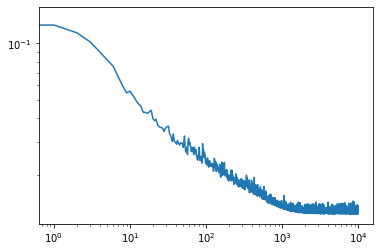

In [15]:
DNN.plot_loss()

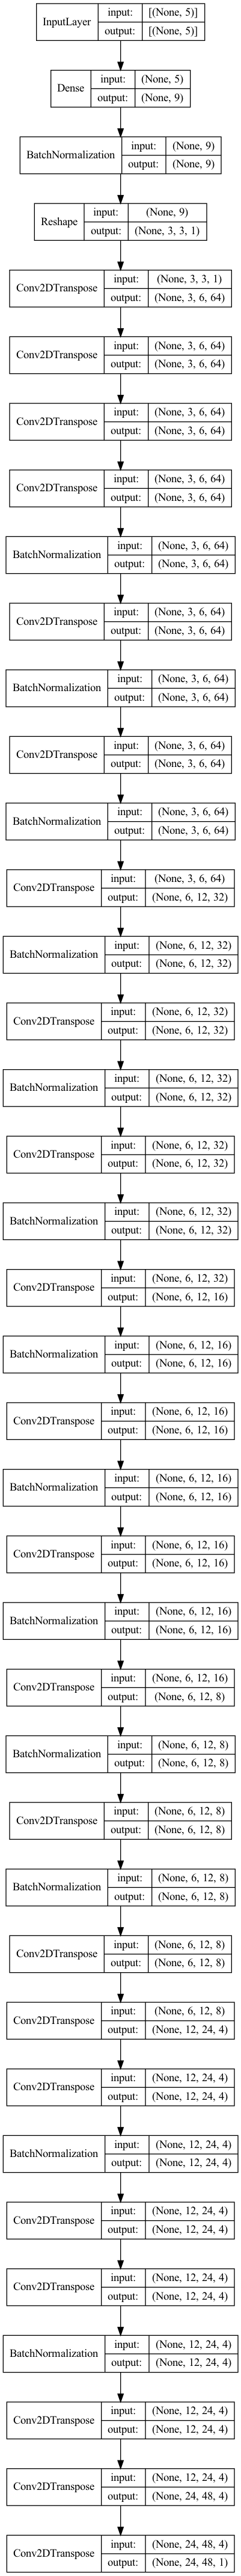

In [16]:
plot_model(DNN.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [17]:
DNN.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 54        
                                                                 
 batch_normalization (BatchN  (None, 9)                36        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 3, 3, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 6, 64)         1664      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 3, 6, 64)         102464    
 ranspose)                                                       
                                                        

In [18]:
def plot(Y_pred,Y_test,i=0):
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    Y_plot=np.reshape(Y_pred[i],(24,48))
    y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_pred",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_pred_xr)
    Y_plot=np.reshape(Y_test[i],(24,48))
    y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
    sample_plot = cviz.contour.plot_lat_lon(
        cmap_name="e3sm_default",
        title="Y_actual",
        rhs_title=r"$W/m^2$",
        lhs_title="Y_E3SM",
    )
    sample_plot.show(y_obs_xr)
    sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
    )
    diff = y_pred_xr-y_obs_xr
    diff[0,0] = 1
    diff[0,1] = -1
    sample_plot.show((diff))

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

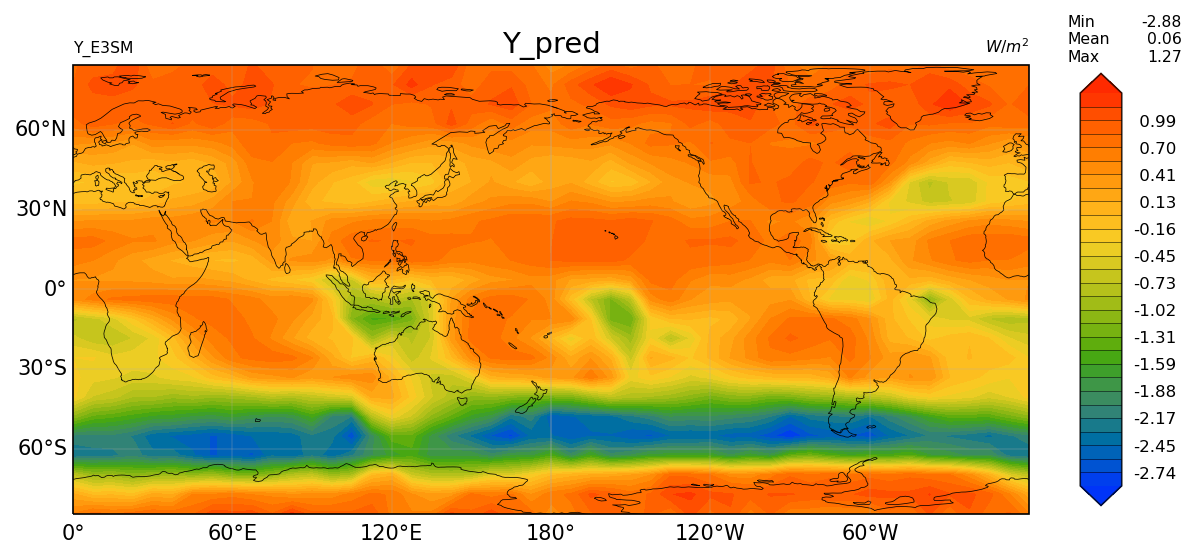

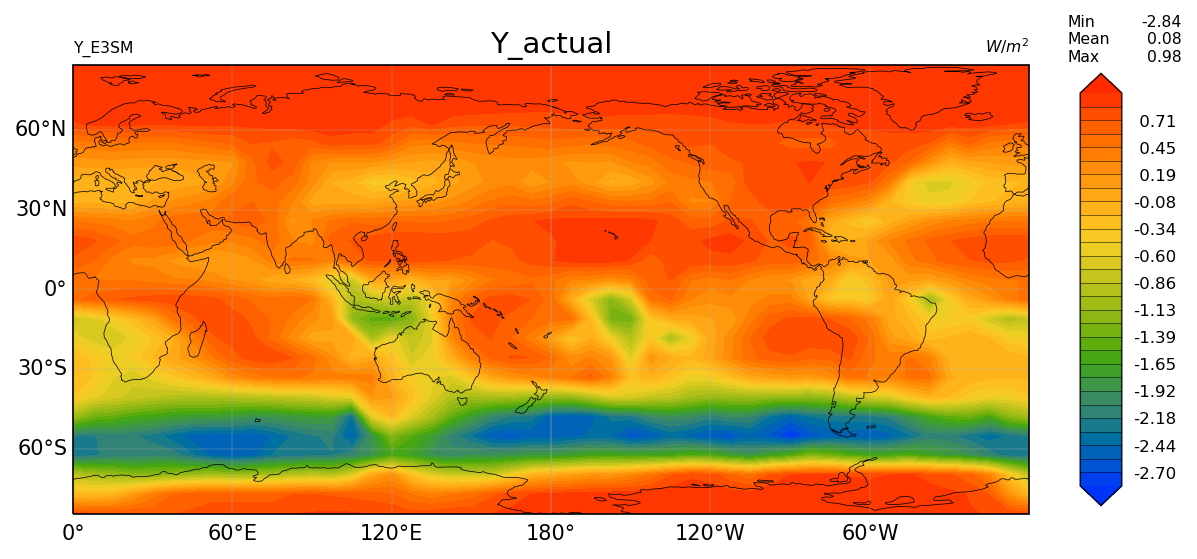

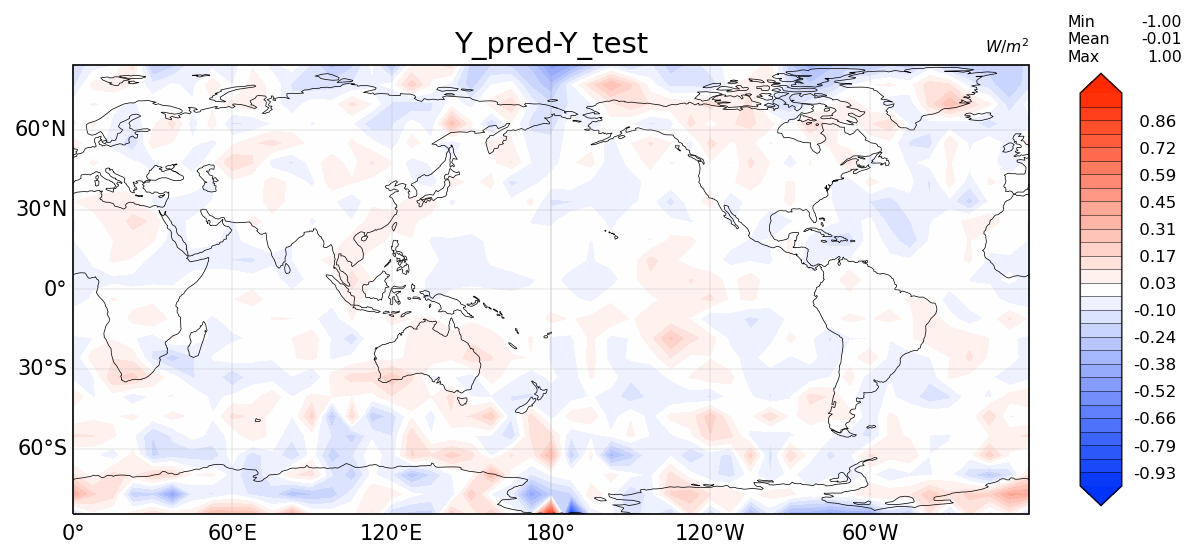

In [19]:
plot(Y_pred,Y_test,-1)

In [20]:
mse_test=np.mean(np.square(Y_pred.squeeze()-Y_test))

In [54]:
mse_test2=np.sum(np.square(Y_pred.squeeze()-Y_test)*weights.reshape(1,-1,1))

In [55]:
mse_test2

17.33048159022868

In [21]:
mse_train=np.mean(np.square(DNN.predict(X_train).squeeze()-Y_train))

In [22]:
mse_test,mse_train

(0.012997083, 0.011943517)

In [58]:
m_test2=np.sum(np.square(Y_test.mean(axis=0)-Y_test)*weights.reshape(1,-1,1))

In [59]:
m_test2

113.40840848091541

In [23]:
x_good=[-0.03182185, -0.37241268,  0.03075755, -0.33797872, 0.28431356]

## Map from Y to X

In [24]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(5,5), strides=(1, 1),activation='leaky_relu',input_shape=(24,48,1),padding='same'))
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same',kernel_regularizer=regularizers.L2(1e-4)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(8*500,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(1000,activation='leaky_relu'))
model2.add(tf.keras.layers.Dense(300,activation='leaky_relu'))
model2.add(tf.keras.layers.Dropout(.2))
model2.add(tf.keras.layers.Dense(100,activation='leaky_relu'))
# model2.add(tf.keras.layers.Dense(5))
model2.add(tf.keras.layers.Dense(5, activation='tanh'))



In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 48, 1)         26        
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 24, 64)        1664      
                                                                 
 batch_normalization_14 (Bat  (None, 12, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 24, 64)        102464    
                                                                 
 batch_normalization_15 (Bat  (None, 12, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 24, 64)       

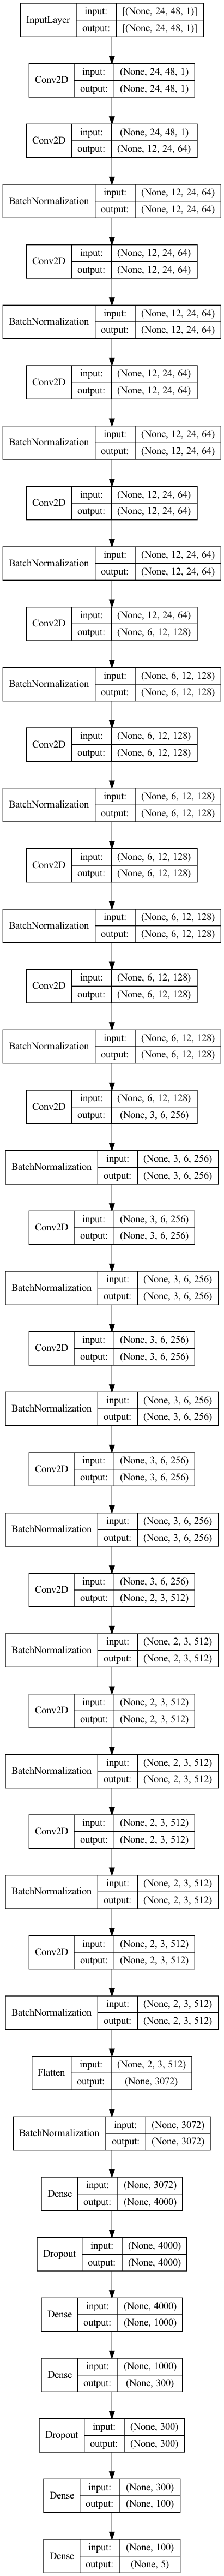

In [26]:
plot_model(model2, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [27]:
def custom_loss2(y_pred,y_actual):
    return kb.square(y_pred-y_actual)

In [28]:
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4,decay_steps=1000,decay_rate=0.95)


In [29]:
model2.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=custom_loss2,
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [30]:
history=model2.fit(Y_train,X_train,epochs=1000)

Epoch 1/1000
7/7 [==============================] - 10s 748ms/step - loss: 1.1552 - root_mean_squared_error: 0.9015
Epoch 2/1000
7/7 [==============================] - 2s 233ms/step - loss: 1.2234 - root_mean_squared_error: 0.9457
Epoch 3/1000
7/7 [==============================] - 2s 340ms/step - loss: 1.2533 - root_mean_squared_error: 0.9670
Epoch 4/1000
7/7 [==============================] - 2s 321ms/step - loss: 1.1794 - root_mean_squared_error: 0.9317
Epoch 5/1000
7/7 [==============================] - 2s 272ms/step - loss: 1.0894 - root_mean_squared_error: 0.8841
Epoch 6/1000
7/7 [==============================] - 2s 300ms/step - loss: 1.0694 - root_mean_squared_error: 0.8735
Epoch 7/1000
7/7 [==============================] - 1s 190ms/step - loss: 1.1031 - root_mean_squared_error: 0.8928
Epoch 8/1000
7/7 [==============================] - 2s 330ms/step - loss: 1.0489 - root_mean_squared_error: 0.8619
Epoch 9/1000
7/7 [==============================] - 2s 234ms/step - loss: 0.977

7/7 [==============================] - 2s 261ms/step - loss: 0.6203 - root_mean_squared_error: 0.5776
Epoch 72/1000
7/7 [==============================] - 2s 248ms/step - loss: 0.6087 - root_mean_squared_error: 0.5682
Epoch 73/1000
7/7 [==============================] - 2s 265ms/step - loss: 0.6108 - root_mean_squared_error: 0.5707
Epoch 74/1000
7/7 [==============================] - 2s 274ms/step - loss: 0.6047 - root_mean_squared_error: 0.5661
Epoch 75/1000
7/7 [==============================] - 2s 281ms/step - loss: 0.5986 - root_mean_squared_error: 0.5614
Epoch 76/1000
7/7 [==============================] - 2s 252ms/step - loss: 0.5978 - root_mean_squared_error: 0.5614
Epoch 77/1000
7/7 [==============================] - 2s 328ms/step - loss: 0.6016 - root_mean_squared_error: 0.5655
Epoch 78/1000
7/7 [==============================] - 2s 235ms/step - loss: 0.6056 - root_mean_squared_error: 0.5698
Epoch 79/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.6042 - ro

7/7 [==============================] - 2s 263ms/step - loss: 0.4721 - root_mean_squared_error: 0.4834
Epoch 142/1000
7/7 [==============================] - 2s 286ms/step - loss: 0.6406 - root_mean_squared_error: 0.6348
Epoch 143/1000
7/7 [==============================] - 2s 345ms/step - loss: 0.6181 - root_mean_squared_error: 0.6171
Epoch 144/1000
7/7 [==============================] - 3s 364ms/step - loss: 0.7698 - root_mean_squared_error: 0.7294
Epoch 145/1000
7/7 [==============================] - 2s 259ms/step - loss: 0.7189 - root_mean_squared_error: 0.6921
Epoch 146/1000
7/7 [==============================] - 2s 296ms/step - loss: 0.6964 - root_mean_squared_error: 0.6743
Epoch 147/1000
7/7 [==============================] - 2s 320ms/step - loss: 0.7383 - root_mean_squared_error: 0.7034
Epoch 148/1000
7/7 [==============================] - 2s 303ms/step - loss: 0.6560 - root_mean_squared_error: 0.6415
Epoch 149/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.5

7/7 [==============================] - 2s 260ms/step - loss: 0.6384 - root_mean_squared_error: 0.6136
Epoch 212/1000
7/7 [==============================] - 2s 255ms/step - loss: 0.6330 - root_mean_squared_error: 0.6097
Epoch 213/1000
7/7 [==============================] - 2s 313ms/step - loss: 0.6049 - root_mean_squared_error: 0.5869
Epoch 214/1000
7/7 [==============================] - 2s 231ms/step - loss: 0.5927 - root_mean_squared_error: 0.5773
Epoch 215/1000
7/7 [==============================] - 2s 279ms/step - loss: 0.5595 - root_mean_squared_error: 0.5488
Epoch 216/1000
7/7 [==============================] - 2s 233ms/step - loss: 0.5634 - root_mean_squared_error: 0.5533
Epoch 217/1000
7/7 [==============================] - 2s 250ms/step - loss: 0.5864 - root_mean_squared_error: 0.5747
Epoch 218/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.5456 - root_mean_squared_error: 0.5390
Epoch 219/1000
7/7 [==============================] - 2s 260ms/step - loss: 0.5

7/7 [==============================] - 2s 276ms/step - loss: 0.5103 - root_mean_squared_error: 0.5383
Epoch 282/1000
7/7 [==============================] - 2s 288ms/step - loss: 0.4981 - root_mean_squared_error: 0.5275
Epoch 283/1000
7/7 [==============================] - 2s 319ms/step - loss: 0.5143 - root_mean_squared_error: 0.5434
Epoch 284/1000
7/7 [==============================] - 2s 309ms/step - loss: 0.5070 - root_mean_squared_error: 0.5375
Epoch 285/1000
7/7 [==============================] - 2s 237ms/step - loss: 0.4888 - root_mean_squared_error: 0.5212
Epoch 286/1000
7/7 [==============================] - 2s 292ms/step - loss: 0.4770 - root_mean_squared_error: 0.5107
Epoch 287/1000
7/7 [==============================] - 2s 311ms/step - loss: 0.4768 - root_mean_squared_error: 0.5114
Epoch 288/1000
7/7 [==============================] - 2s 292ms/step - loss: 0.4654 - root_mean_squared_error: 0.5012
Epoch 289/1000
7/7 [==============================] - 2s 247ms/step - loss: 0.4

7/7 [==============================] - 2s 303ms/step - loss: 0.4633 - root_mean_squared_error: 0.5299
Epoch 352/1000
7/7 [==============================] - 2s 265ms/step - loss: 0.4382 - root_mean_squared_error: 0.5065
Epoch 353/1000
7/7 [==============================] - 2s 294ms/step - loss: 0.4316 - root_mean_squared_error: 0.5009
Epoch 354/1000
7/7 [==============================] - 2s 319ms/step - loss: 0.4438 - root_mean_squared_error: 0.5139
Epoch 355/1000
7/7 [==============================] - 2s 303ms/step - loss: 0.4349 - root_mean_squared_error: 0.5060
Epoch 356/1000
7/7 [==============================] - 2s 245ms/step - loss: 0.4387 - root_mean_squared_error: 0.5107
Epoch 357/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.4227 - root_mean_squared_error: 0.4957
Epoch 358/1000
7/7 [==============================] - 2s 290ms/step - loss: 0.4290 - root_mean_squared_error: 0.5030
Epoch 359/1000
7/7 [==============================] - 2s 275ms/step - loss: 0.4

7/7 [==============================] - 2s 282ms/step - loss: 0.3814 - root_mean_squared_error: 0.5014
Epoch 422/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.3595 - root_mean_squared_error: 0.4796
Epoch 423/1000
7/7 [==============================] - 2s 310ms/step - loss: 0.3604 - root_mean_squared_error: 0.4811
Epoch 424/1000
7/7 [==============================] - 2s 293ms/step - loss: 0.3684 - root_mean_squared_error: 0.4900
Epoch 425/1000
7/7 [==============================] - 2s 316ms/step - loss: 0.3645 - root_mean_squared_error: 0.4865
Epoch 426/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.3686 - root_mean_squared_error: 0.4913
Epoch 427/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.3664 - root_mean_squared_error: 0.4895
Epoch 428/1000
7/7 [==============================] - 2s 301ms/step - loss: 0.3733 - root_mean_squared_error: 0.4971
Epoch 429/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.3

7/7 [==============================] - 2s 324ms/step - loss: 0.3834 - root_mean_squared_error: 0.5188
Epoch 492/1000
7/7 [==============================] - 2s 304ms/step - loss: 0.3742 - root_mean_squared_error: 0.5105
Epoch 493/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.3707 - root_mean_squared_error: 0.5076
Epoch 494/1000
7/7 [==============================] - 2s 338ms/step - loss: 0.3538 - root_mean_squared_error: 0.4914
Epoch 495/1000
7/7 [==============================] - 2s 300ms/step - loss: 0.3695 - root_mean_squared_error: 0.5077
Epoch 496/1000
7/7 [==============================] - 2s 283ms/step - loss: 0.3717 - root_mean_squared_error: 0.5105
Epoch 497/1000
7/7 [==============================] - 2s 342ms/step - loss: 0.3646 - root_mean_squared_error: 0.5042
Epoch 498/1000
7/7 [==============================] - 2s 314ms/step - loss: 0.3683 - root_mean_squared_error: 0.5084
Epoch 499/1000
7/7 [==============================] - 2s 268ms/step - loss: 0.3

7/7 [==============================] - 2s 279ms/step - loss: 0.3203 - root_mean_squared_error: 0.4853
Epoch 562/1000
7/7 [==============================] - 2s 288ms/step - loss: 0.3208 - root_mean_squared_error: 0.4863
Epoch 563/1000
7/7 [==============================] - 2s 282ms/step - loss: 0.3336 - root_mean_squared_error: 0.4997
Epoch 564/1000
7/7 [==============================] - 2s 271ms/step - loss: 0.3184 - root_mean_squared_error: 0.4847
Epoch 565/1000
7/7 [==============================] - 2s 277ms/step - loss: 0.3130 - root_mean_squared_error: 0.4795
Epoch 566/1000
7/7 [==============================] - 2s 233ms/step - loss: 0.3184 - root_mean_squared_error: 0.4855
Epoch 567/1000
7/7 [==============================] - 2s 284ms/step - loss: 0.3338 - root_mean_squared_error: 0.5016
Epoch 568/1000
7/7 [==============================] - 2s 267ms/step - loss: 0.3096 - root_mean_squared_error: 0.4772
Epoch 569/1000
7/7 [==============================] - 2s 270ms/step - loss: 0.3

7/7 [==============================] - 2s 326ms/step - loss: 0.4851 - root_mean_squared_error: 0.6449
Epoch 632/1000
7/7 [==============================] - 2s 257ms/step - loss: 0.4509 - root_mean_squared_error: 0.6125
Epoch 633/1000
7/7 [==============================] - 2s 288ms/step - loss: 0.4517 - root_mean_squared_error: 0.6067
Epoch 634/1000
7/7 [==============================] - 2s 321ms/step - loss: 0.4370 - root_mean_squared_error: 0.5903
Epoch 635/1000
7/7 [==============================] - 2s 254ms/step - loss: 0.4344 - root_mean_squared_error: 0.5860
Epoch 636/1000
7/7 [==============================] - 2s 276ms/step - loss: 0.4201 - root_mean_squared_error: 0.5727
Epoch 637/1000
7/7 [==============================] - 2s 308ms/step - loss: 0.4090 - root_mean_squared_error: 0.5626
Epoch 638/1000
7/7 [==============================] - 2s 312ms/step - loss: 0.4422 - root_mean_squared_error: 0.5910
Epoch 639/1000
7/7 [==============================] - 2s 268ms/step - loss: 0.4

7/7 [==============================] - 2s 295ms/step - loss: 0.4251 - root_mean_squared_error: 0.5416
Epoch 702/1000
7/7 [==============================] - 2s 306ms/step - loss: 0.4229 - root_mean_squared_error: 0.5406
Epoch 703/1000
7/7 [==============================] - 2s 297ms/step - loss: 0.4135 - root_mean_squared_error: 0.5328
Epoch 704/1000
7/7 [==============================] - 2s 279ms/step - loss: 0.4122 - root_mean_squared_error: 0.5326
Epoch 705/1000
7/7 [==============================] - 2s 281ms/step - loss: 0.4208 - root_mean_squared_error: 0.5415
Epoch 706/1000
7/7 [==============================] - 2s 321ms/step - loss: 0.4233 - root_mean_squared_error: 0.5447
Epoch 707/1000
7/7 [==============================] - 2s 278ms/step - loss: 0.4265 - root_mean_squared_error: 0.5484
Epoch 708/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.4149 - root_mean_squared_error: 0.5384
Epoch 709/1000
7/7 [==============================] - 2s 296ms/step - loss: 0.4

7/7 [==============================] - 2s 332ms/step - loss: 0.4122 - root_mean_squared_error: 0.5455
Epoch 772/1000
7/7 [==============================] - 2s 230ms/step - loss: 0.4104 - root_mean_squared_error: 0.5446
Epoch 773/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.4008 - root_mean_squared_error: 0.5365
Epoch 774/1000
7/7 [==============================] - 2s 354ms/step - loss: 0.3991 - root_mean_squared_error: 0.5357
Epoch 775/1000
7/7 [==============================] - 2s 322ms/step - loss: 0.4000 - root_mean_squared_error: 0.5373
Epoch 776/1000
7/7 [==============================] - 2s 254ms/step - loss: 0.4014 - root_mean_squared_error: 0.5394
Epoch 777/1000
7/7 [==============================] - 2s 305ms/step - loss: 0.3879 - root_mean_squared_error: 0.5274
Epoch 778/1000
7/7 [==============================] - 2s 342ms/step - loss: 0.3982 - root_mean_squared_error: 0.5379
Epoch 779/1000
7/7 [==============================] - 2s 291ms/step - loss: 0.4

7/7 [==============================] - 2s 241ms/step - loss: 0.3388 - root_mean_squared_error: 0.5009
Epoch 842/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.3494 - root_mean_squared_error: 0.5117
Epoch 843/1000
7/7 [==============================] - 2s 256ms/step - loss: 0.3469 - root_mean_squared_error: 0.5097
Epoch 844/1000
7/7 [==============================] - 2s 276ms/step - loss: 0.3427 - root_mean_squared_error: 0.5060
Epoch 845/1000
7/7 [==============================] - 2s 274ms/step - loss: 0.3195 - root_mean_squared_error: 0.4831
Epoch 846/1000
7/7 [==============================] - 2s 278ms/step - loss: 0.3222 - root_mean_squared_error: 0.4865
Epoch 847/1000
7/7 [==============================] - 2s 252ms/step - loss: 0.3194 - root_mean_squared_error: 0.4842
Epoch 848/1000
7/7 [==============================] - 2s 317ms/step - loss: 0.3105 - root_mean_squared_error: 0.4755
Epoch 849/1000
7/7 [==============================] - 2s 253ms/step - loss: 0.3

7/7 [==============================] - 2s 274ms/step - loss: 0.3637 - root_mean_squared_error: 0.5391
Epoch 912/1000
7/7 [==============================] - 2s 331ms/step - loss: 0.3701 - root_mean_squared_error: 0.5448
Epoch 913/1000
7/7 [==============================] - 2s 312ms/step - loss: 0.3608 - root_mean_squared_error: 0.5362
Epoch 914/1000
7/7 [==============================] - 2s 297ms/step - loss: 0.3483 - root_mean_squared_error: 0.5241
Epoch 915/1000
7/7 [==============================] - 2s 304ms/step - loss: 0.3573 - root_mean_squared_error: 0.5309
Epoch 916/1000
7/7 [==============================] - 2s 294ms/step - loss: 0.3940 - root_mean_squared_error: 0.5628
Epoch 917/1000
7/7 [==============================] - 2s 325ms/step - loss: 0.3821 - root_mean_squared_error: 0.5510
Epoch 918/1000
7/7 [==============================] - 2s 301ms/step - loss: 0.4198 - root_mean_squared_error: 0.5832
Epoch 919/1000
7/7 [==============================] - 2s 279ms/step - loss: 0.3

7/7 [==============================] - 2s 281ms/step - loss: 0.2983 - root_mean_squared_error: 0.4829
Epoch 982/1000
7/7 [==============================] - 2s 261ms/step - loss: 0.4350 - root_mean_squared_error: 0.6085
Epoch 983/1000
7/7 [==============================] - 2s 317ms/step - loss: 0.6290 - root_mean_squared_error: 0.7505
Epoch 984/1000
7/7 [==============================] - 2s 244ms/step - loss: 0.5165 - root_mean_squared_error: 0.6683
Epoch 985/1000
7/7 [==============================] - 2s 300ms/step - loss: 0.4594 - root_mean_squared_error: 0.6205
Epoch 986/1000
7/7 [==============================] - 2s 274ms/step - loss: 0.4611 - root_mean_squared_error: 0.6198
Epoch 987/1000
7/7 [==============================] - 2s 264ms/step - loss: 0.4419 - root_mean_squared_error: 0.6033
Epoch 988/1000
7/7 [==============================] - 2s 283ms/step - loss: 0.4758 - root_mean_squared_error: 0.6306
Epoch 989/1000
7/7 [==============================] - 2s 297ms/step - loss: 0.4

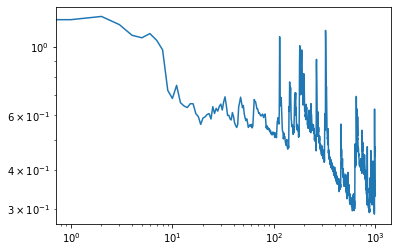

In [31]:
plt.loglog(history.history['loss'])

In [32]:
x_pred=model2.predict(Y_test)

In [33]:
x_pred

array([[ 8.52115750e-02,  9.91665483e-01,  7.41897881e-01,
         9.98288453e-01, -9.00636375e-01],
       [-1.48571849e-01, -1.02203138e-01, -8.51951689e-02,
         9.94250238e-01, -8.67416799e-01],
       [-9.50235873e-02,  5.39265215e-01,  2.12712556e-01,
         9.97938454e-01, -8.82702053e-01],
       [ 4.52941395e-02,  9.87985551e-01,  7.17644930e-01,
         9.99228358e-01, -9.10069704e-01],
       [ 1.66632747e-03,  9.90486503e-01,  7.50115395e-01,
         9.99856234e-01, -9.40134048e-01],
       [ 3.83532606e-02,  9.87411380e-01,  7.15083778e-01,
         9.99329746e-01, -9.12085116e-01],
       [ 2.55980920e-02,  9.89922404e-01,  7.39639103e-01,
         9.99684155e-01, -9.27441299e-01],
       [-5.97732700e-02,  8.80477548e-01,  4.60770309e-01,
         9.98464286e-01, -8.68439615e-01],
       [ 9.38876718e-02,  9.91303086e-01,  7.35512972e-01,
         9.97448981e-01, -8.92305911e-01],
       [ 4.70377393e-02,  9.82746959e-01,  6.79222167e-01,
         9.98521864e-01

In [34]:
x_pred.min(),x_pred.max()

(-0.9483439, 0.9998999)

In [35]:
model2.evaluate(Y_train,X_train)

7/7 [==============================] - 2s 79ms/step - loss: 0.9891 - root_mean_squared_error: 0.9581


[0.9890797734260559, 0.9580710530281067]

In [36]:
model2.evaluate(Y_test,X_test)

2/2 [==============================] - 1s 390ms/step - loss: 0.9441 - root_mean_squared_error: 0.9343


[0.9440904855728149, 0.9342970848083496]

In [37]:
Y_obs_re=Y_obs.reshape(1,24,48)

In [38]:
x_obs_a=model2.predict(Y_obs_re)

In [39]:
x_obs_a

array([[ 0.10368209,  0.99213374,  0.74069786,  0.99682766, -0.88985157]],
      dtype=float32)

In [75]:
feature_transform.inverse_transform(x_obs_a)

array([[ 9.29433095e+02,  4.98426747e+00,  4.48139572e-01,
         1.43800143e+04, -1.89535899e-03]])

In [40]:
Y_obs_pred=DNN.predict(x_obs_a)

In [41]:
np.min(np.array(model2.weights[-1]))

-0.027473068

[[ 0.47363523  0.6680532   0.82821816 ...  1.0611508   0.85573757
   0.7727188 ]
 [ 0.660396    0.75390965  1.0212097  ...  0.60841465  0.67681086
   0.3549436 ]
 [-0.09403144  0.04724661  0.1891121  ... -0.5775027  -0.64377636
  -0.3615337 ]
 ...
 [ 0.7786559   0.85684407  0.9310249  ...  0.9786637   1.115747
   0.863445  ]
 [ 0.71913123  0.9869235   1.1616538  ...  0.9274439   1.0115526
   0.8104305 ]
 [ 0.5255345   0.61858726  0.78186035 ...  0.77999055  0.78103304
   0.73748314]]


/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

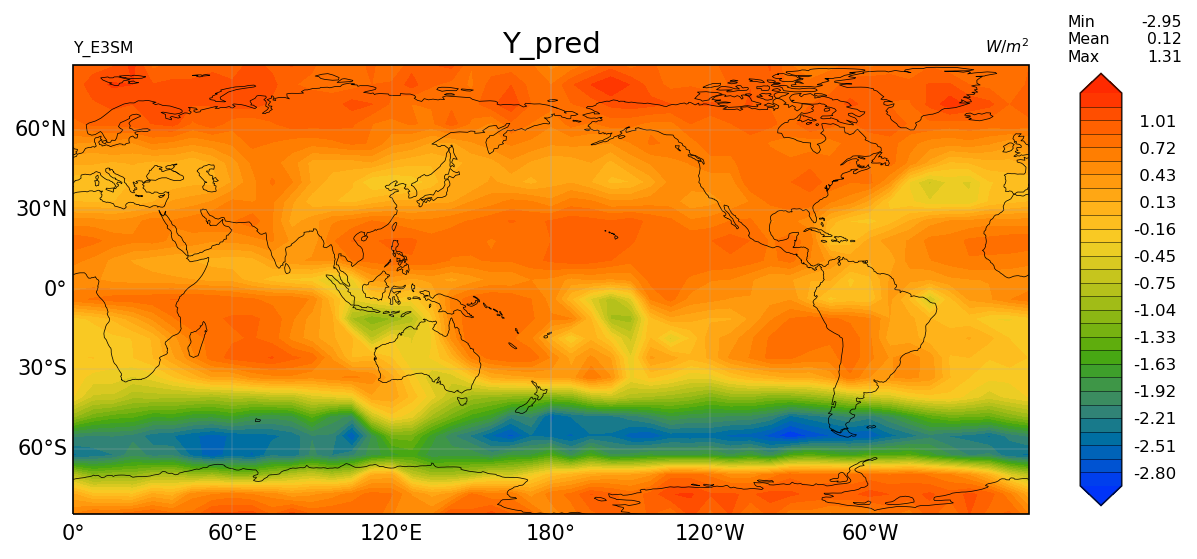

In [42]:
lat = dataset['lat'].values
lon = dataset['lon'].values
Y_plot=np.reshape(Y_obs_pred,(24,48))
print(Y_plot)
y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_pred",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_pred_xr)

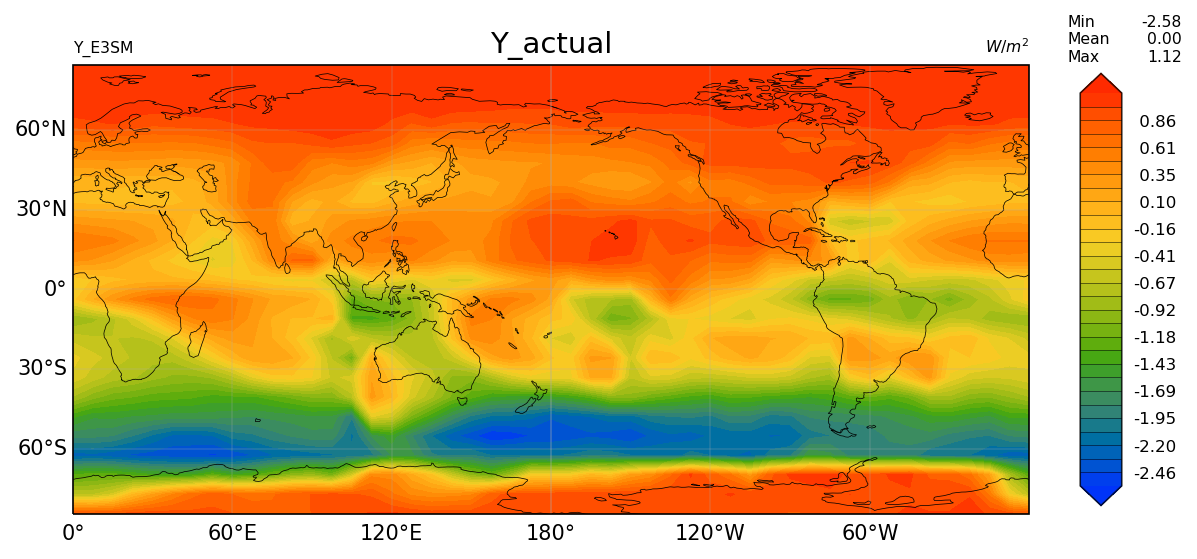

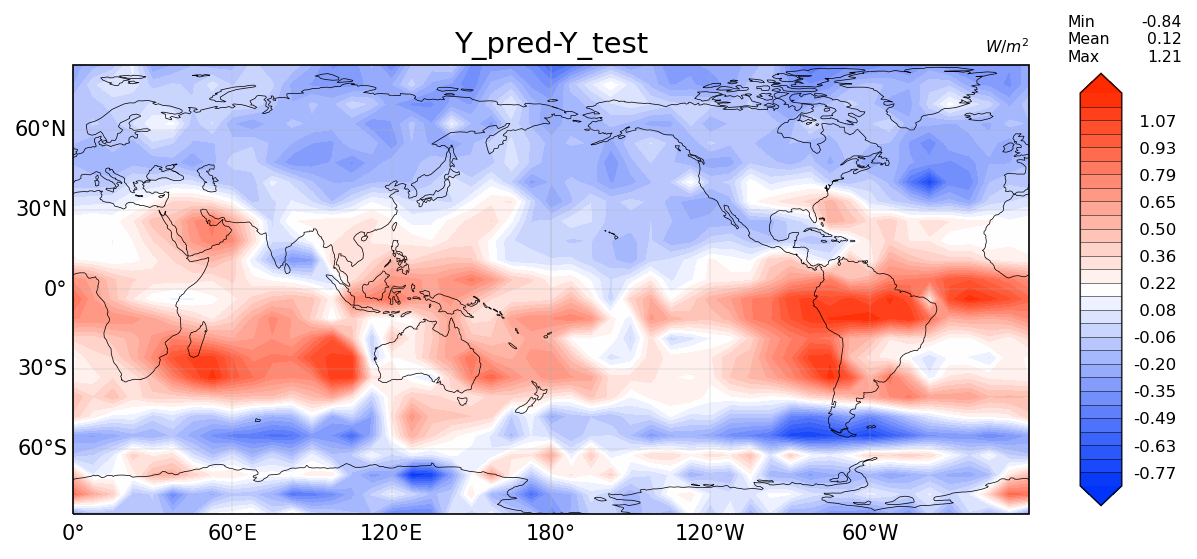

In [43]:
Y_plot=np.reshape(Y_obs,(24,48))
y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_actual",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_obs_xr)
sample_plot = cviz.contour.plot_lat_lon(
cmap_name="e3sm_default_diff",
title="Y_pred-Y_test",
rhs_title=r"$W/m^2$",
lhs_title="",
)
sample_plot.show((y_pred_xr-y_obs_xr))

In [44]:
np.mean(np.square(Y_obs-Y_obs_pred.squeeze()))

0.14835237

In [45]:
np.min(np.mean(np.square(Y_obs-Y), axis=(1,2)))

0.059853606

In [46]:
np.mean(np.square(Y_obs-Y[196].squeeze()))

0.059853606

In [47]:
Y_obs.shape

(24, 48)

## Custom Loss 2

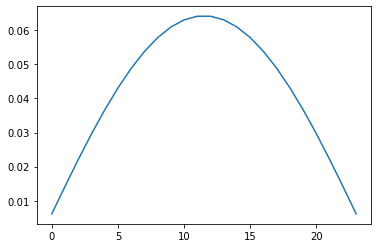

In [111]:
area_weight_arr/=sum(area_weight_arr)
plt.plot(area_weight_arr)
area_weight_arr=np.array(area_weight.mean(dim="lon").values,dtype='float32')

In [112]:
class DeConvNeuralNetwork2(BaseEstimator):
    def __init__(self,area_weight_arr,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
        self.area_weight_arr=area_weight_arr
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred
#         z=kb.exp(-kb.abs(kb.arange(24,dtype=float)-11.5)/2+1e-15)
#         weights=z/kb.sum(z)
        weights=self.area_weight_arr/kb.sum(self.area_weight_arr)

        custom_loss=kb.mean(err**2* kb.reshape(weights,(1,-1,1)))**0.5
        #custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [113]:
Dnn2= DeConvNeuralNetwork2(area_weight_arr,epochs=2000)

In [114]:
Dnn2.fit(X_train,Y_train)

Epoch 1/2000
7/7 [==============================] - 2s 77ms/step - loss: 0.1943 - root_mean_squared_error: 1.0215
Epoch 2/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.1779 - root_mean_squared_error: 0.9500
Epoch 3/2000
7/7 [==============================] - 0s 27ms/step - loss: 0.1595 - root_mean_squared_error: 0.8568
Epoch 4/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.1367 - root_mean_squared_error: 0.7338
Epoch 5/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.1150 - root_mean_squared_error: 0.6182
Epoch 6/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0977 - root_mean_squared_error: 0.5315
Epoch 7/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0860 - root_mean_squared_error: 0.4611
Epoch 8/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0764 - root_mean_squared_error: 0.4041
Epoch 9/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0672 - root_m

7/7 [==============================] - 0s 22ms/step - loss: 0.0276 - root_mean_squared_error: 0.1304
Epoch 73/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0257 - root_mean_squared_error: 0.1231
Epoch 74/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0255 - root_mean_squared_error: 0.1215
Epoch 75/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0250 - root_mean_squared_error: 0.1195
Epoch 76/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0258 - root_mean_squared_error: 0.1228
Epoch 77/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0242 - root_mean_squared_error: 0.1164
Epoch 78/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0255 - root_mean_squared_error: 0.1207
Epoch 79/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0246 - root_mean_squared_error: 0.1176
Epoch 80/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0258 - root_mean_s

Epoch 143/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0233 - root_mean_squared_error: 0.1094
Epoch 144/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0210 - root_mean_squared_error: 0.1003
Epoch 145/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0211 - root_mean_squared_error: 0.1006
Epoch 146/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0205 - root_mean_squared_error: 0.0980
Epoch 147/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0210 - root_mean_squared_error: 0.1002
Epoch 148/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0211 - root_mean_squared_error: 0.1006
Epoch 149/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0201 - root_mean_squared_error: 0.0964
Epoch 150/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0204 - root_mean_squared_error: 0.0974
Epoch 151/2000
7/7 [==============================] - 0s 22ms/step - los

7/7 [==============================] - 0s 22ms/step - loss: 0.0194 - root_mean_squared_error: 0.0924
Epoch 214/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0198 - root_mean_squared_error: 0.0939
Epoch 215/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0209 - root_mean_squared_error: 0.0981
Epoch 216/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0205 - root_mean_squared_error: 0.0973
Epoch 217/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.0195 - root_mean_squared_error: 0.0931
Epoch 218/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0188 - root_mean_squared_error: 0.0899
Epoch 219/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0186 - root_mean_squared_error: 0.0894
Epoch 220/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0189 - root_mean_squared_error: 0.0903
Epoch 221/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0180 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0179 - root_mean_squared_error: 0.0860
Epoch 284/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.0822
Epoch 285/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0173 - root_mean_squared_error: 0.0833
Epoch 286/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - root_mean_squared_error: 0.0847
Epoch 287/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - root_mean_squared_error: 0.0848
Epoch 288/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0175 - root_mean_squared_error: 0.0840
Epoch 289/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0173 - root_mean_squared_error: 0.0830
Epoch 290/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0170 - root_mean_squared_error: 0.0823
Epoch 291/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0177 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0172 - root_mean_squared_error: 0.0822
Epoch 354/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0180 - root_mean_squared_error: 0.0854
Epoch 355/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0169 - root_mean_squared_error: 0.0810
Epoch 356/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0171 - root_mean_squared_error: 0.0818
Epoch 357/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0166 - root_mean_squared_error: 0.0800
Epoch 358/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0167 - root_mean_squared_error: 0.0805
Epoch 359/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0166 - root_mean_squared_error: 0.0800
Epoch 360/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0164 - root_mean_squared_error: 0.0791
Epoch 361/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0171 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0170 - root_mean_squared_error: 0.0814
Epoch 424/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0179 - root_mean_squared_error: 0.0846
Epoch 425/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0173 - root_mean_squared_error: 0.0826
Epoch 426/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0162 - root_mean_squared_error: 0.0784
Epoch 427/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0167 - root_mean_squared_error: 0.0804
Epoch 428/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0164 - root_mean_squared_error: 0.0788
Epoch 429/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0171 - root_mean_squared_error: 0.0824
Epoch 430/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.0773
Epoch 431/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0164 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0156 - root_mean_squared_error: 0.0754
Epoch 494/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0152 - root_mean_squared_error: 0.0740
Epoch 495/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0155 - root_mean_squared_error: 0.0751
Epoch 496/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0159 - root_mean_squared_error: 0.0765
Epoch 497/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0158 - root_mean_squared_error: 0.0766
Epoch 498/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0159 - root_mean_squared_error: 0.0766
Epoch 499/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0156 - root_mean_squared_error: 0.0757
Epoch 500/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0157 - root_mean_squared_error: 0.0761
Epoch 501/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0155 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0726
Epoch 564/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0727
Epoch 565/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0157 - root_mean_squared_error: 0.0753
Epoch 566/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.0739
Epoch 567/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0157 - root_mean_squared_error: 0.0756
Epoch 568/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.0740
Epoch 569/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0151 - root_mean_squared_error: 0.0735
Epoch 570/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0149 - root_mean_squared_error: 0.0726
Epoch 571/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.0722
Epoch 634/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0150 - root_mean_squared_error: 0.0730
Epoch 635/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.0732
Epoch 636/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0151 - root_mean_squared_error: 0.0730
Epoch 637/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0146 - root_mean_squared_error: 0.0714
Epoch 638/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0150 - root_mean_squared_error: 0.0728
Epoch 639/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.0721
Epoch 640/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0717
Epoch 641/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0152 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0145 - root_mean_squared_error: 0.0709
Epoch 704/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0704
Epoch 705/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0717
Epoch 706/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0704
Epoch 707/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0717
Epoch 708/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.0720
Epoch 709/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.0729
Epoch 710/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0147 - root_mean_squared_error: 0.0715
Epoch 711/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - roo

7/7 [==============================] - 0s 20ms/step - loss: 0.0142 - root_mean_squared_error: 0.0695
Epoch 774/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.0142 - root_mean_squared_error: 0.0693
Epoch 775/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0140 - root_mean_squared_error: 0.0687
Epoch 776/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0145 - root_mean_squared_error: 0.0708
Epoch 777/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0148 - root_mean_squared_error: 0.0719
Epoch 778/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0704
Epoch 779/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0142 - root_mean_squared_error: 0.0695
Epoch 780/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0146 - root_mean_squared_error: 0.0709
Epoch 781/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.0144 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0141 - root_mean_squared_error: 0.0691
Epoch 844/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0141 - root_mean_squared_error: 0.0690
Epoch 845/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0141 - root_mean_squared_error: 0.0688
Epoch 846/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0140 - root_mean_squared_error: 0.0686
Epoch 847/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0141 - root_mean_squared_error: 0.0691
Epoch 848/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.0723
Epoch 849/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0149 - root_mean_squared_error: 0.0722
Epoch 850/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - root_mean_squared_error: 0.0694
Epoch 851/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0137 - root_mean_squared_error: 0.0674
Epoch 914/2000
7/7 [==============================] - 0s 29ms/step - loss: 0.0142 - root_mean_squared_error: 0.0694
Epoch 915/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0139 - root_mean_squared_error: 0.0682
Epoch 916/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0139 - root_mean_squared_error: 0.0679
Epoch 917/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0143 - root_mean_squared_error: 0.0696
Epoch 918/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0680
Epoch 919/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0141 - root_mean_squared_error: 0.0688
Epoch 920/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - root_mean_squared_error: 0.0702
Epoch 921/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0138 - root_mean_squared_error: 0.0677
Epoch 984/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0140 - root_mean_squared_error: 0.0682
Epoch 985/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0140 - root_mean_squared_error: 0.0685
Epoch 986/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0672
Epoch 987/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0142 - root_mean_squared_error: 0.0688
Epoch 988/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0678
Epoch 989/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0673
Epoch 990/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 991/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - roo

7/7 [==============================] - 0s 21ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1054/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0135 - root_mean_squared_error: 0.0665
Epoch 1055/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1056/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1057/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1058/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0668
Epoch 1059/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0679
Epoch 1060/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0673
Epoch 1061/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1124/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0134 - root_mean_squared_error: 0.0661
Epoch 1125/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0673
Epoch 1126/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1127/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0667
Epoch 1128/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0661
Epoch 1129/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.0668
Epoch 1130/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0678
Epoch 1131/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0656
Epoch 1194/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0138 - root_mean_squared_error: 0.0674
Epoch 1195/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0657
Epoch 1196/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0135 - root_mean_squared_error: 0.0663
Epoch 1197/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0137 - root_mean_squared_error: 0.0670
Epoch 1198/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.0660
Epoch 1199/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0135 - root_mean_squared_error: 0.0660
Epoch 1200/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.0662
Epoch 1201/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1264/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0652
Epoch 1265/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0655
Epoch 1266/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0135 - root_mean_squared_error: 0.0663
Epoch 1267/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0135 - root_mean_squared_error: 0.0661
Epoch 1268/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1269/2000
7/7 [==============================] - 0s 25ms/step - loss: 0.0133 - root_mean_squared_error: 0.0658
Epoch 1270/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0658
Epoch 1271/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0653
Epoch 1334/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0649
Epoch 1335/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0652
Epoch 1336/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0647
Epoch 1337/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0652
Epoch 1338/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.0654
Epoch 1339/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.0655
Epoch 1340/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0649
Epoch 1341/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1404/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0651
Epoch 1405/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.0656
Epoch 1406/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0134 - root_mean_squared_error: 0.0660
Epoch 1407/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0136 - root_mean_squared_error: 0.0669
Epoch 1408/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.0648
Epoch 1409/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0650
Epoch 1410/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1411/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0648
Epoch 1474/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0647
Epoch 1475/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0650
Epoch 1476/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0132 - root_mean_squared_error: 0.0651
Epoch 1477/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0649
Epoch 1478/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1479/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0643
Epoch 1480/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0643
Epoch 1481/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.01

7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1544/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0647
Epoch 1545/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0135 - root_mean_squared_error: 0.0660
Epoch 1546/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0130 - root_mean_squared_error: 0.0644
Epoch 1547/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.0648
Epoch 1548/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0132 - root_mean_squared_error: 0.0649
Epoch 1549/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1550/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0133 - root_mean_squared_error: 0.0654
Epoch 1551/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0134 - root_mean_squared_error: 0.0657
Epoch 1614/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1615/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1616/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0638
Epoch 1617/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0637
Epoch 1618/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0637
Epoch 1619/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1620/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1621/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1684/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1685/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1686/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0132 - root_mean_squared_error: 0.0650
Epoch 1687/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0131 - root_mean_squared_error: 0.0645
Epoch 1688/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1689/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1690/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1691/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0639
Epoch 1754/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1755/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0133 - root_mean_squared_error: 0.0651
Epoch 1756/2000
7/7 [==============================] - 0s 24ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1757/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1758/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1759/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0133 - root_mean_squared_error: 0.0653
Epoch 1760/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1761/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.01

7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1824/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1825/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1826/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1827/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1828/2000
7/7 [==============================] - 0s 23ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1829/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1830/2000
7/7 [==============================] - 0s 26ms/step - loss: 0.0130 - root_mean_squared_error: 0.0640
Epoch 1831/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0133 - root_mean_squared_error: 0.0651
Epoch 1894/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0636
Epoch 1895/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0646
Epoch 1896/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0130 - root_mean_squared_error: 0.0638
Epoch 1897/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0130 - root_mean_squared_error: 0.0642
Epoch 1898/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0643
Epoch 1899/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0130 - root_mean_squared_error: 0.0639
Epoch 1900/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.0642
Epoch 1901/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.01

7/7 [==============================] - 0s 21ms/step - loss: 0.0129 - root_mean_squared_error: 0.0636
Epoch 1964/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0644
Epoch 1965/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0634
Epoch 1966/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.0129 - root_mean_squared_error: 0.0635
Epoch 1967/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0643
Epoch 1968/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0131 - root_mean_squared_error: 0.0645
Epoch 1969/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0128 - root_mean_squared_error: 0.0634
Epoch 1970/2000
7/7 [==============================] - 0s 21ms/step - loss: 0.0130 - root_mean_squared_error: 0.0641
Epoch 1971/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.01

(<keras.engine.sequential.Sequential at 0x303bb5b80>,
 <keras.callbacks.History at 0x30424ec70>)

In [116]:
Dnn2.evaluate(X_train,Y_train)

7/7 [==============================] - 1s 27ms/step - loss: 0.0126 - root_mean_squared_error: 0.0624


[0.012578227557241917, 0.062356214970350266]

In [117]:
Dnn2.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 120ms/step - loss: 0.0151 - root_mean_squared_error: 0.0711


[0.015063583850860596, 0.07106980681419373]

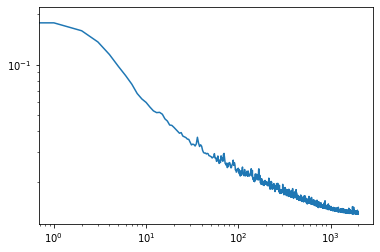

In [119]:
Dnn2.plot_loss()

In [120]:
Y_pred2=Dnn2.predict(X_test)

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

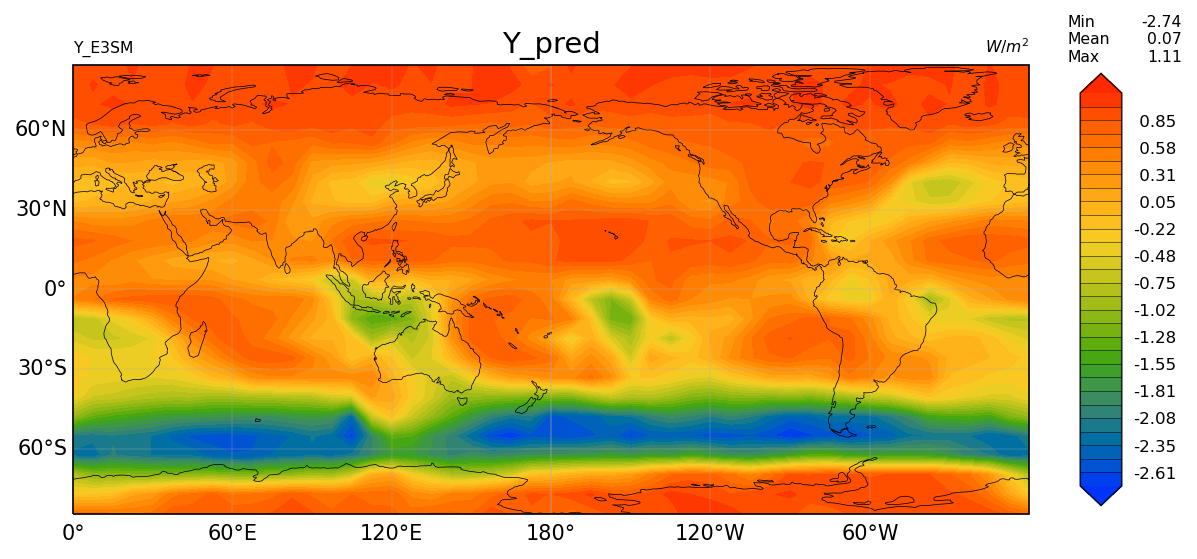

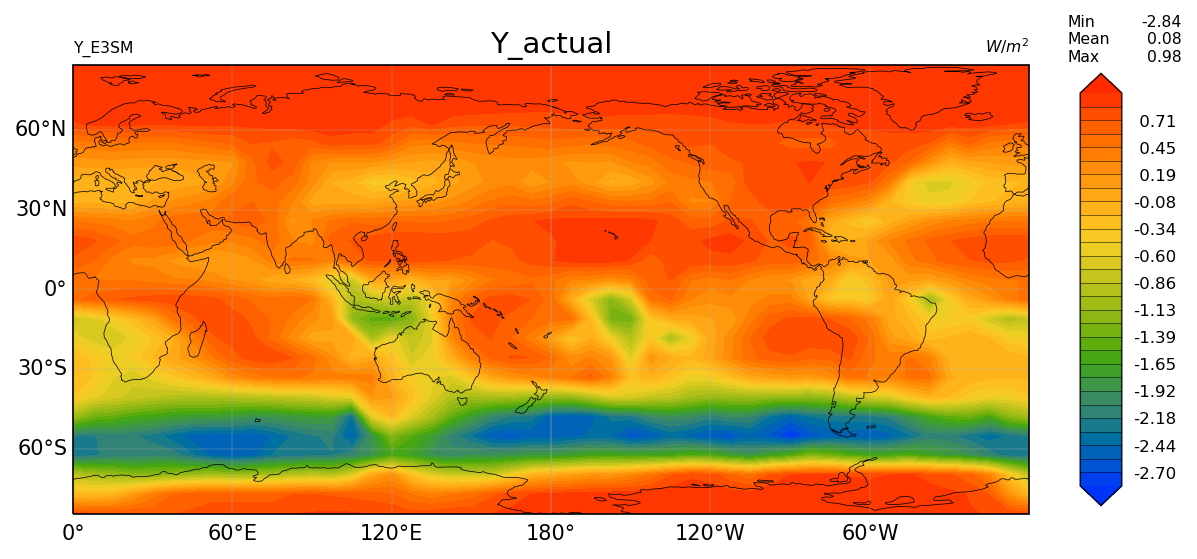

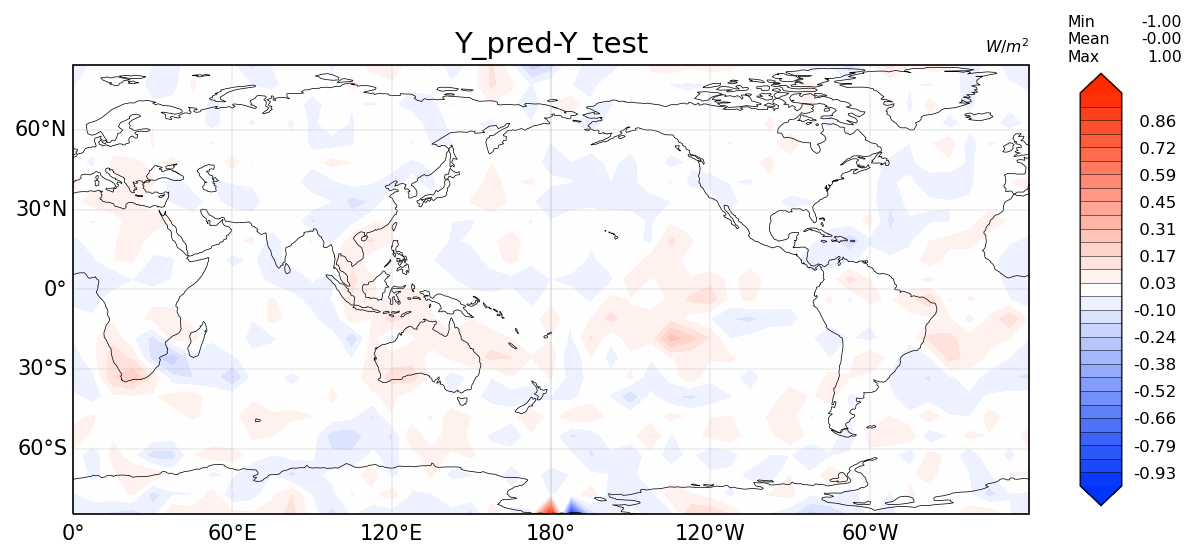

In [121]:
plot(Y_pred2,Y_test,-1)

## MSE

In [122]:
class DeConvNeuralNetwork_orig(BaseEstimator):
    def __init__(self,area_weight_arr,learning_rate=1e-4,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.model=None
        self.area_weight_arr=area_weight_arr
    def custom_loss(self,y_actual,y_pred):
        err=y_actual-y_pred


        custom_loss=kb.square(y_actual-y_pred)
        return custom_loss
    def fit(self,X,y=None,**fit_params):
        '''
        create a sequentil neural network
        add layers and activations
        model = Sequential(...)
        model.fit(X,y)
        '''
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=5))
        model.add(tf.keras.layers.Dense(9, activation='leaky_relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Reshape((3,3,1)))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(1, 1), activation='leaky_relu', padding='same'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=(5,5), strides=(2, 2), activation='leaky_relu', padding='same'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(3,3), strides=(1, 1), padding='same'))
        lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=1000,decay_rate=0.7)
        model.compile(optimizer=tf.optimizers.Adam(lr_schedule),loss=self.custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
        history=model.fit(X,y,epochs=self.epochs)
        self.history=history
        self.model=model
        return model,history
    def predict(self,X):
        '''
        model.predict(X)
        '''
        self.model.predict(X)
        return self.model.predict(X)
    def plot_loss(self):
        if self.history is not None:
            plt.loglog(self.history.history['loss'])
            
    def evaluate(self,X,Y):
        return self.model.evaluate(X,Y)
    def plot_model(self,to_file='large_model_plot.png', show_shapes=True, show_layer_names=False):
        plot_model(self.model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)

In [128]:
Dnn3= DeConvNeuralNetwork_orig(area_weight_arr,epochs=1000)

In [130]:
Dnn3.fit(X_train,Y_train)

Epoch 1/1000
7/7 [==============================] - 2s 102ms/step - loss: 1.0363 - root_mean_squared_error: 1.0180
Epoch 2/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.8684 - root_mean_squared_error: 0.9319
Epoch 3/1000
7/7 [==============================] - 0s 30ms/step - loss: 0.6796 - root_mean_squared_error: 0.8244
Epoch 4/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.4947 - root_mean_squared_error: 0.7033
Epoch 5/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.3476 - root_mean_squared_error: 0.5896
Epoch 6/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.2434 - root_mean_squared_error: 0.4933
Epoch 7/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
Epoch 8/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.1582 - root_mean_squared_error: 0.3978
Epoch 9/1000
7/7 [==============================] - 0s 27ms/step - loss: 0.1303 - root_

7/7 [==============================] - 0s 22ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479
Epoch 73/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447
Epoch 74/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415
Epoch 75/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375
Epoch 76/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426
Epoch 77/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409
Epoch 78/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460
Epoch 79/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550
Epoch 80/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0202 - root_mean_s

Epoch 143/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143
Epoch 144/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147
Epoch 145/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120
Epoch 146/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118
Epoch 147/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110
Epoch 148/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151
Epoch 149/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123
Epoch 150/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145
Epoch 151/1000
7/7 [==============================] - 0s 22ms/step - los

7/7 [==============================] - 0s 21ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006
Epoch 214/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998
Epoch 215/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005
Epoch 216/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974
Epoch 217/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977
Epoch 218/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986
Epoch 219/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978
Epoch 220/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984
Epoch 221/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0093 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949
Epoch 284/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928
Epoch 285/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927
Epoch 286/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918
Epoch 287/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909
Epoch 288/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907
Epoch 289/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921
Epoch 290/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905
Epoch 291/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0082 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864
Epoch 354/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867
Epoch 355/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880
Epoch 356/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859
Epoch 357/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872
Epoch 358/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862
Epoch 359/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863
Epoch 360/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852
Epoch 361/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0071 - roo

7/7 [==============================] - 0s 24ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844
Epoch 424/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855
Epoch 425/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829
Epoch 426/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818
Epoch 427/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830
Epoch 428/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820
Epoch 429/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835
Epoch 430/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832
Epoch 431/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0072 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836
Epoch 494/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826
Epoch 495/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807
Epoch 496/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790
Epoch 497/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801
Epoch 498/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820
Epoch 499/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794
Epoch 500/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789
Epoch 501/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0065 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788
Epoch 564/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786
Epoch 565/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791
Epoch 566/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772
Epoch 567/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768
Epoch 568/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773
Epoch 569/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793
Epoch 570/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775
Epoch 571/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0060 - roo

7/7 [==============================] - 0s 26ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748
Epoch 634/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750
Epoch 635/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748
Epoch 636/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760
Epoch 637/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743
Epoch 638/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748
Epoch 639/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767
Epoch 640/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0056 - root_mean_squared_error: 0.0745
Epoch 641/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0057 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732
Epoch 704/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727
Epoch 705/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737
Epoch 706/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740
Epoch 707/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752
Epoch 708/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731
Epoch 709/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730
Epoch 710/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750
Epoch 711/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0054 - roo

7/7 [==============================] - 0s 25ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735
Epoch 774/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736
Epoch 775/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731
Epoch 776/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731
Epoch 777/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725
Epoch 778/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724
Epoch 779/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720
Epoch 780/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710
Epoch 781/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0051 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710
Epoch 844/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712
Epoch 845/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705
Epoch 846/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725
Epoch 847/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740
Epoch 848/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742
Epoch 849/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707
Epoch 850/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711
Epoch 851/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0052 - roo

7/7 [==============================] - 0s 23ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698
Epoch 914/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696
Epoch 915/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705
Epoch 916/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721
Epoch 917/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714
Epoch 918/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703
Epoch 919/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696
Epoch 920/1000
7/7 [==============================] - 0s 26ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691
Epoch 921/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0052 - roo

7/7 [==============================] - 0s 22ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686
Epoch 984/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676
Epoch 985/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694
Epoch 986/1000
7/7 [==============================] - 0s 23ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688
Epoch 987/1000
7/7 [==============================] - 0s 25ms/step - loss: 0.0047 - root_mean_squared_error: 0.0689
Epoch 988/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692
Epoch 989/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685
Epoch 990/1000
7/7 [==============================] - 0s 22ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700
Epoch 991/1000
7/7 [==============================] - 0s 24ms/step - loss: 0.0053 - roo

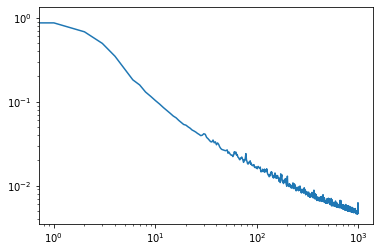

In [135]:
Dnn3.plot_loss()

In [131]:
Y_pred3=Dnn3.predict(X_test)

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

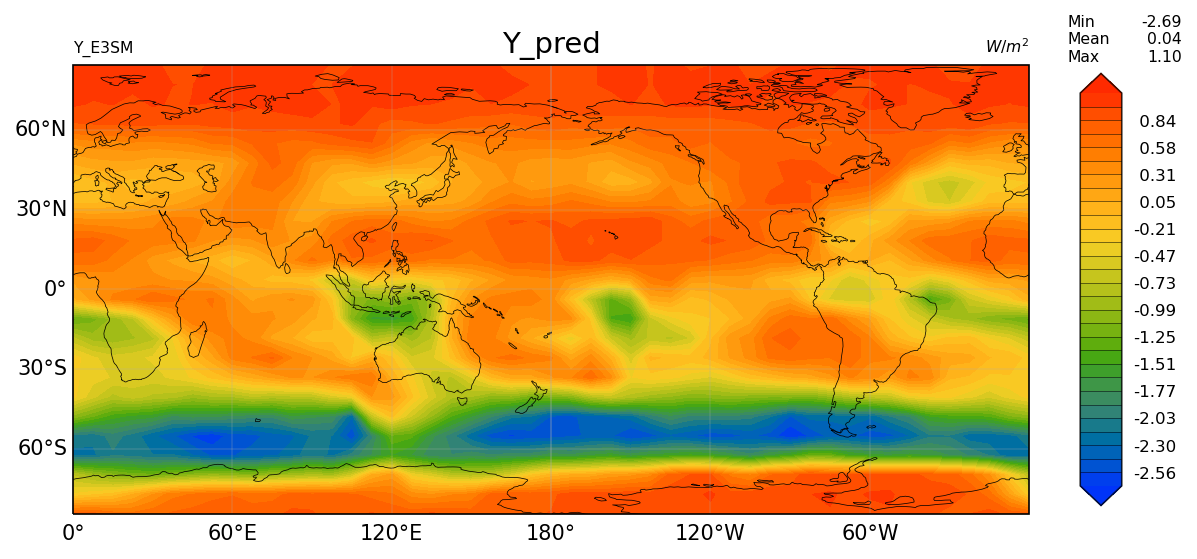

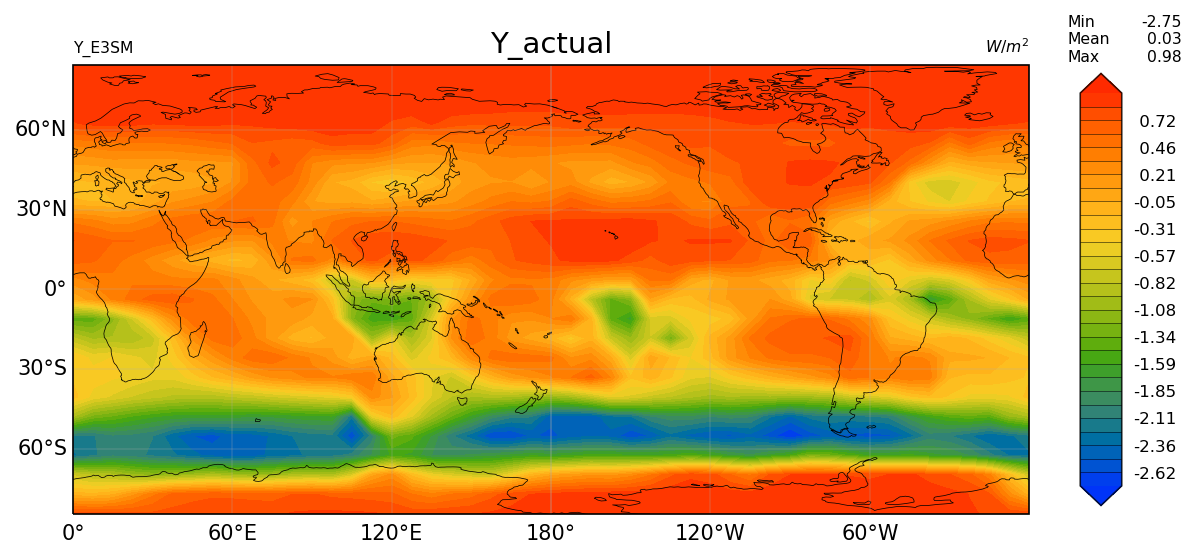

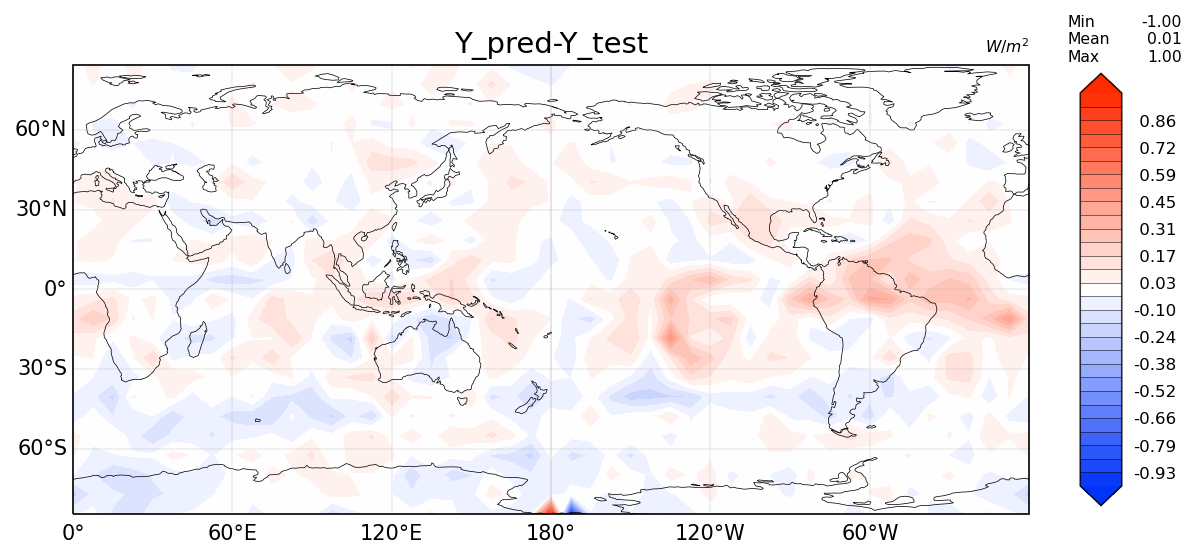

In [136]:
plot(Y_pred3,Y_test,-3)

In [133]:
Dnn3.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 112ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721


[0.005200606305152178, 0.07211523503065109]